<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

<div style="width:700px;background:#F9EECF;border:1px solid black;text-align:center;padding:8px;">


<b style="font-size:18pt">Exploratory Data Analysis and Data Cleaning</b>
<br>



</div>

### Data dictionary
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [2]:
# Load the data
house1 = pd.read_csv('./housing.csv')
house2 = pd.read_csv('./housing.csv')

### Remove non-residential houses from data

As we are only predicting housing prices of non-residential data, let's remove the non-residential data using a mask on the dataframe.

In [3]:
print house1.shape
search_for = ['FV', 'RH', 'RL', 'RP', 'RM']
mask = house1['MSZoning'].isin(search_for)
house1 = house1.loc[mask, :]
house1.shape


(1460, 81)


(1450, 81)

### Identify outliers in SalePrice

As expected of most housing price datasets, the sale price is positively skewed. I want to remove outliers, as outliers affect the accuracy of our regressor model later.

I use StandardScaler to represent the highest and lowest house prices in terms of standard deviation from the mean. As we can see, there are some pretty crazy outliers that are 5 or 7 standard deviations higher than the mean price.

/home/james/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Lower Range of house prices
[[-1.81625312]
 [-1.798565  ]
 [-1.6381085 ]
 [-1.63179132]
 [-1.60020539]
 [-1.60020539]
 [-1.5559851 ]
 [-1.53703354]
 [-1.53703354]
 [-1.53703354]]
Higher Range of the house prices
[[ 3.83257369]
 [ 4.04529857]
 [ 4.50219529]
 [ 4.71697958]
 [ 4.73695452]
 [ 5.06989544]
 [ 5.43280508]
 [ 5.60138548]
 [ 7.11750987]
 [ 7.24385357]]


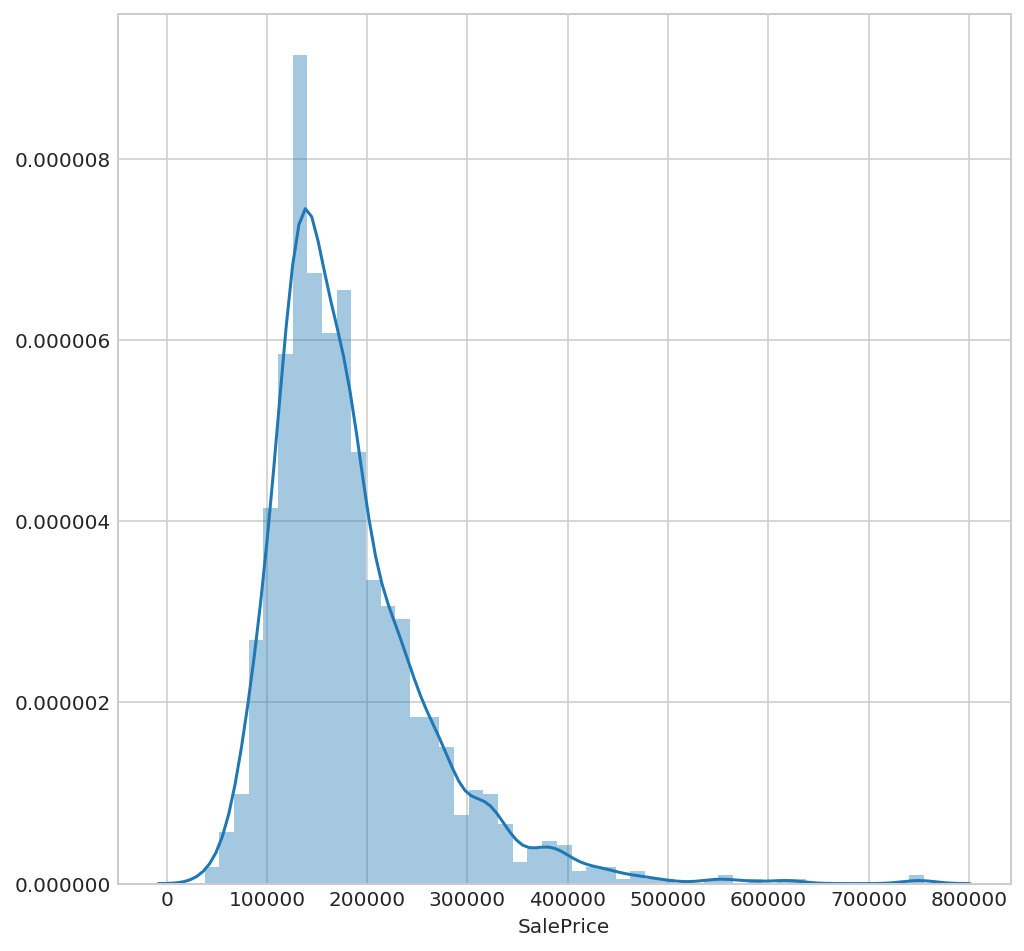

In [4]:
plt.figure(figsize=(8,8))
sns.distplot(house1['SalePrice'])

target_scaled = StandardScaler().fit_transform(house1['SalePrice'][:,np.newaxis])
low_range = target_scaled[target_scaled[:,0].argsort()][:10]
high_range = target_scaled[target_scaled[:,0].argsort()][-10:]
print 'Lower Range of house prices'
print low_range
print 'Higher Range of the house prices'
print high_range

# Some pretty crazy outliers in the 5+, 7+ range. 

house1.nlargest(5, 'SalePrice').index

house1.drop(house1.nlargest(5, 'SalePrice').index, inplace=True)

### Detecting outliers in our data visually

Plot some of our features gainst the target variables in a scatter plot.

There are some pretty obvious outliers in GrLivArea, LotArea, and 1stFlrSF. My decisions to the outliers are: 

* Drop all records where 'GrLvArea' => 4000

* Drop all records where 'LotArea' => 20000

* Drop all records where 'GrLvArea' => 4000




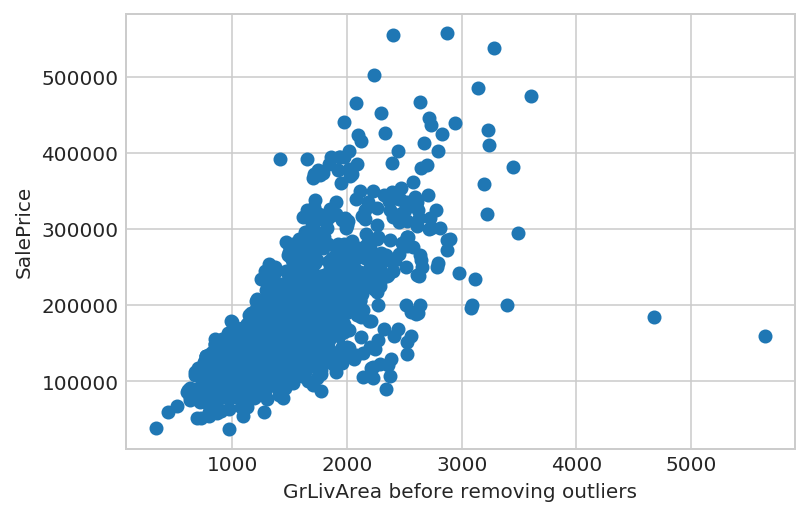

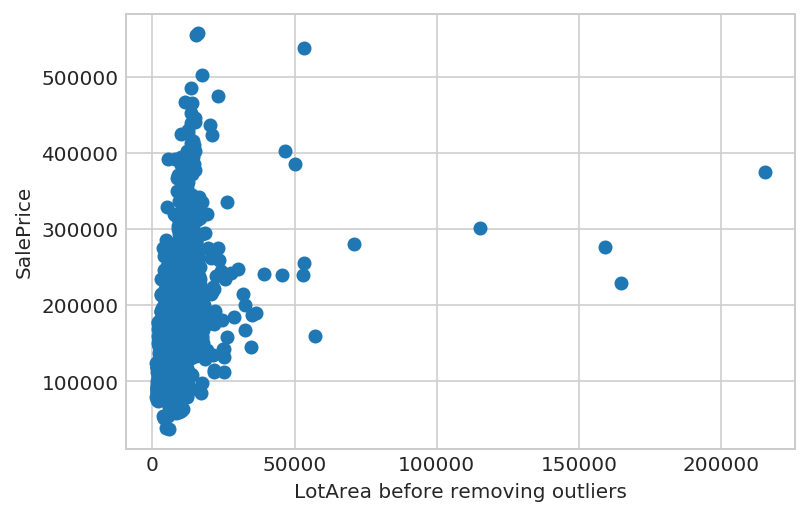

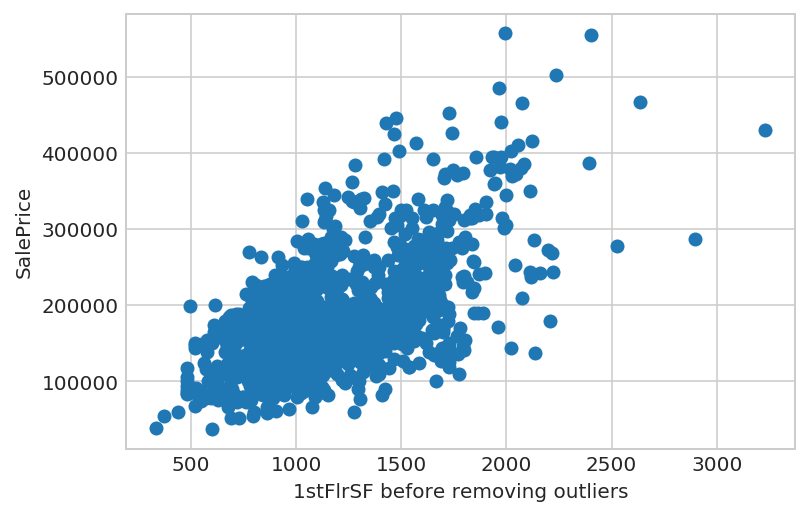

In [5]:
#plt.subplot(121)
plt.scatter(house1.GrLivArea, house1.SalePrice)
plt.xlabel('GrLivArea before removing outliers')
plt.ylabel('SalePrice')
plt.show()

house1 = house1[house1['GrLivArea'] < 4000]
#GrLivArea outliers handled.

plt.scatter(house1.LotArea, house1.SalePrice)
plt.xlabel('LotArea before removing outliers')
plt.ylabel('SalePrice')
plt.show()

house1 = house1[house1['LotArea'] < 20000] 
#LotArea outliers handled. 

plt.scatter(house1['1stFlrSF'], house1.SalePrice)
plt.xlabel('1stFlrSF before removing outliers')
plt.ylabel('SalePrice') 

to_drop = house1.loc[ house1['1stFlrSF']>2000,:].loc[house1['SalePrice'] <300000,:]
house1.drop(to_drop.index, axis=0, inplace=True)
plt.show()

house2 = house1.copy()



In [6]:
to_drop = house1.loc[ house1['1stFlrSF']>2000,:].loc[house1['SalePrice'] <300000,:]
house1.drop(to_drop.index, axis=0, inplace=True)
plt.show()

house2 = house1.copy()


### After removing the outliers

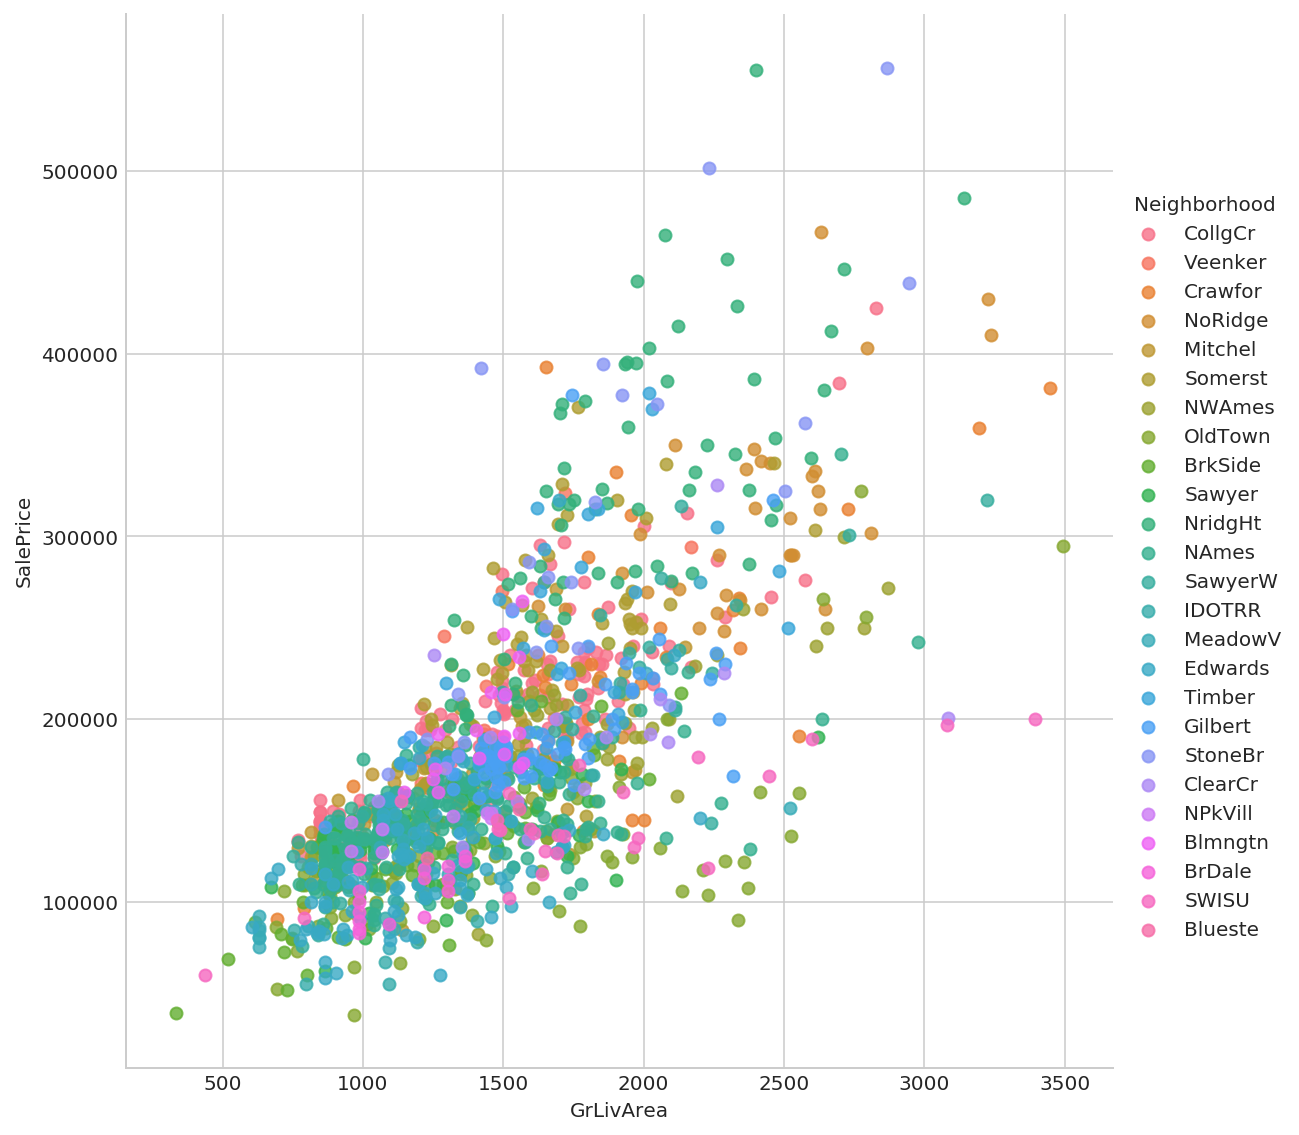

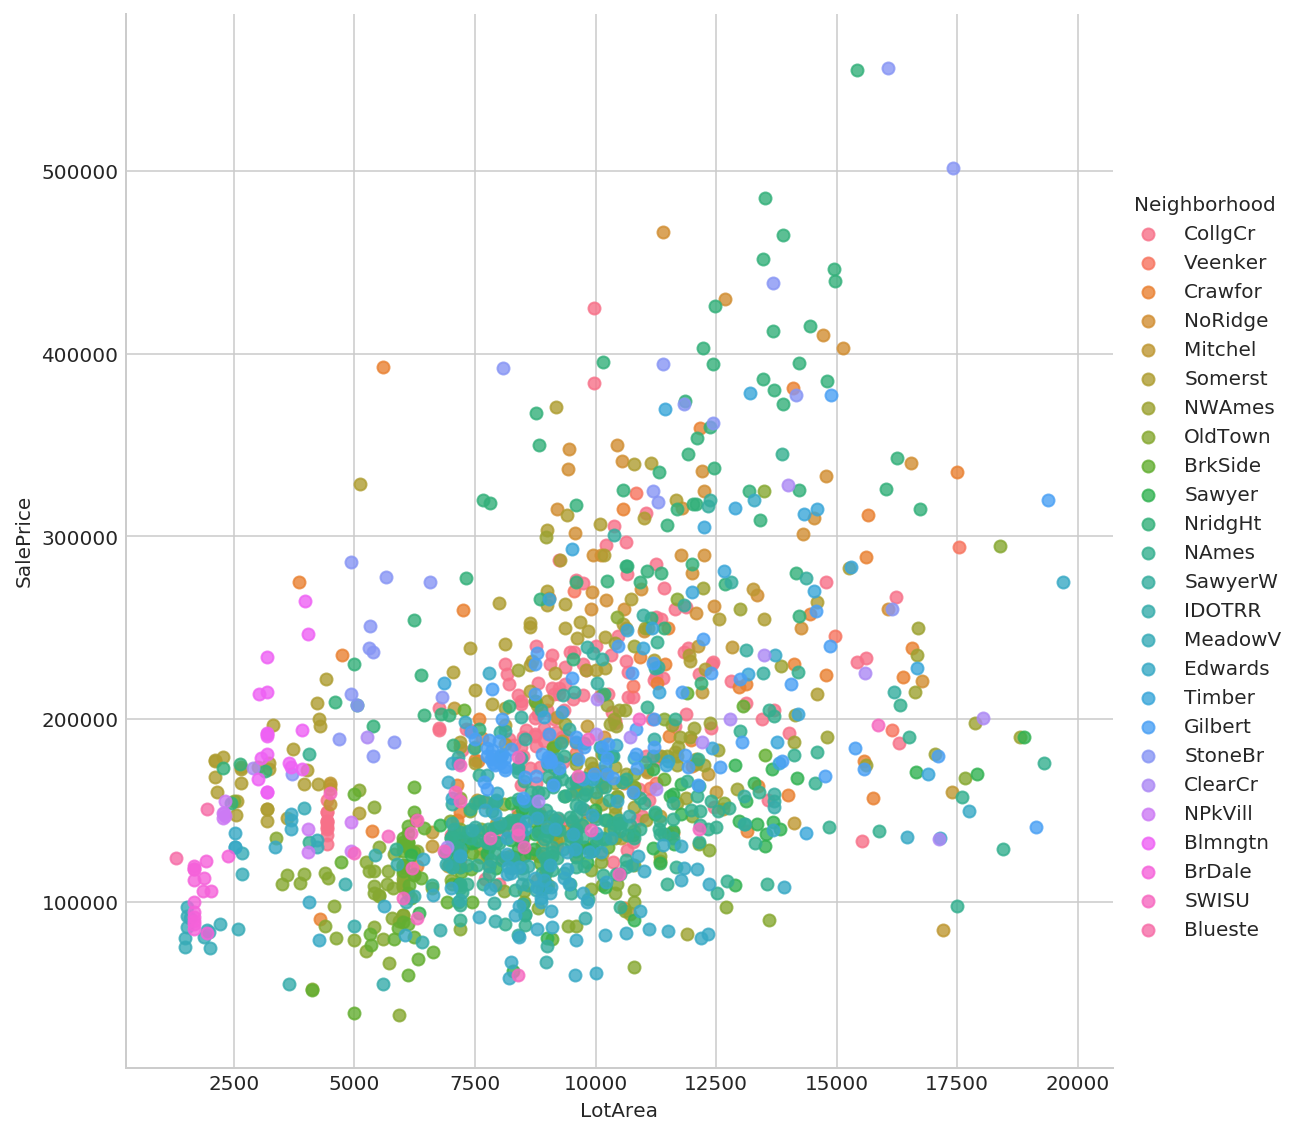

(162, 81)
(162, 81)


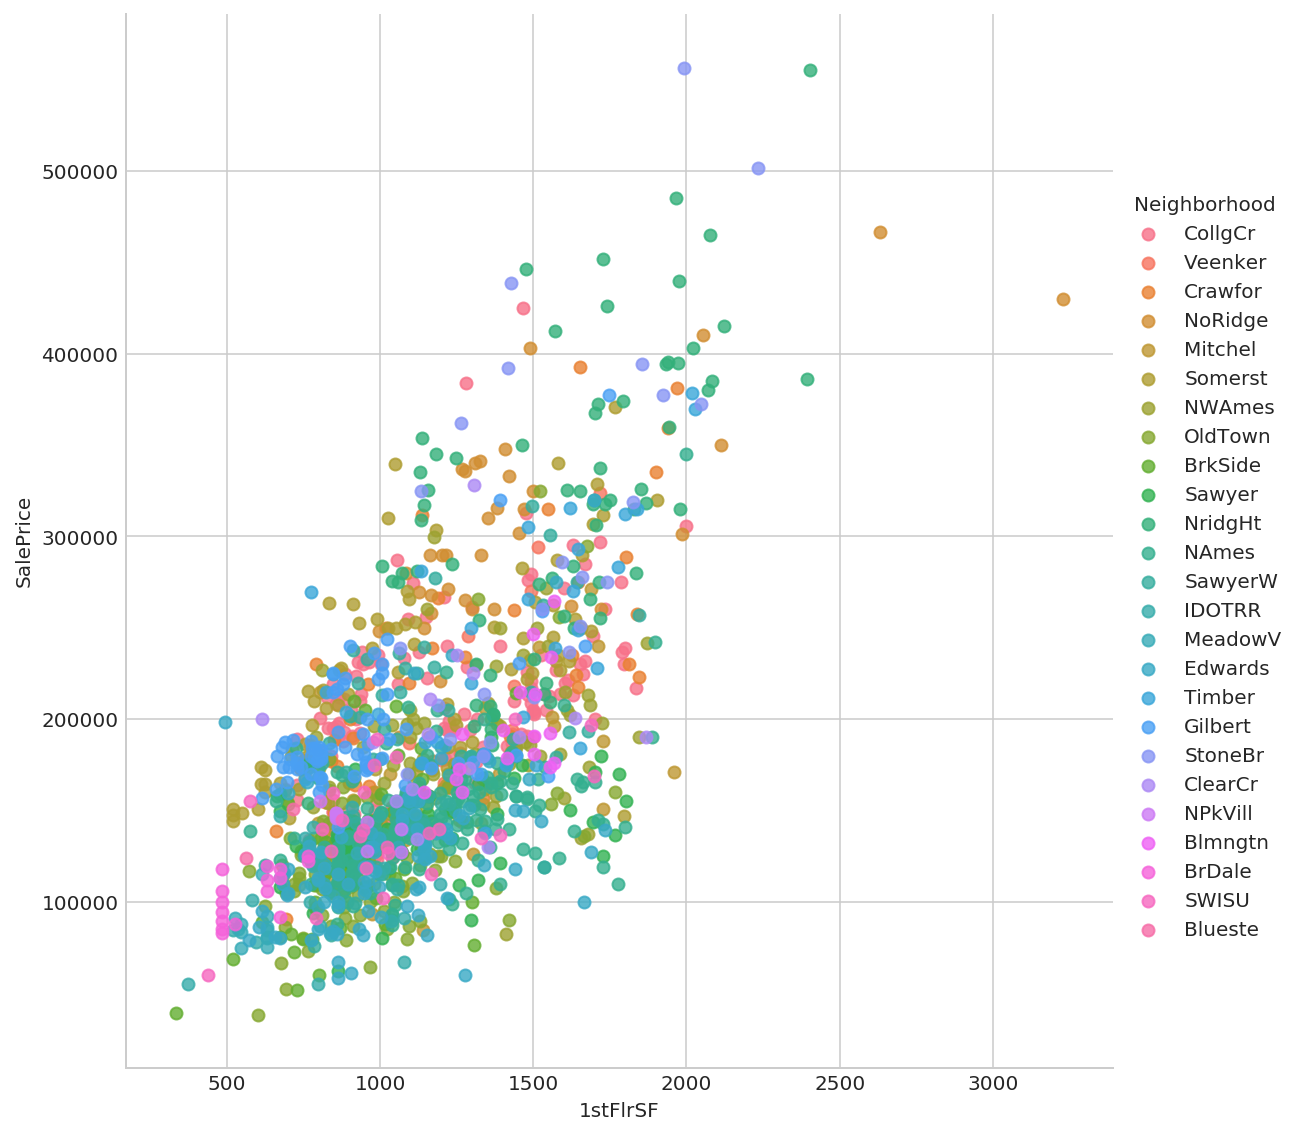

In [7]:
sns.lmplot(x="GrLivArea", y = "SalePrice", hue="Neighborhood", data=house1, fit_reg=False, size=8)
plt.show()
sns.lmplot(x="LotArea", y = "SalePrice", hue="Neighborhood", data=house1, fit_reg=False, size=8)
plt.show()
sns.lmplot(x="1stFlrSF", y = "SalePrice", hue="Neighborhood", data=house1, fit_reg=False, size=8)


#A lot of outliers in LotArea and SalePrice. I want to Remove LotArea > 50,000 and SalePrice > 500,000 
#house1 = house1[house1['SalePrice'] < 500000]
#house1 = house1[house1['LotArea'] < 50000]
#sns.lmplot(x="SalePrice", y = "LotArea", hue="Neighborhood", data=house1, fit_reg=False, size=12)

#neigh = house1[house1['LotArea'] < 20000]
#neigh2 = neigh[neigh['SalePrice'] < 400000]
#sns.lmplot(x="SalePrice", y = "LotArea", hue="Neighborhood", data=neigh2, fit_reg=False, size = 10)
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape



### 1. Identify fixed and un-fixed features, remove un-fixed features.

Since the task is to create a prediction model based on the fixed features of a house, I've decided to drop features that are describe a house's unfixed features. 

The data dictionary provides a brief description of each of the features, so it is up to me to decide which are fixed or unfixed features.


In [8]:
#All columns that have 'Qual' or 'Cond' are unfixed features. so, remove. 
unfixed_features = []
unfixed_features.append(house1.loc[:,house1.columns.str.contains('Qual')].columns)
unfixed_features.append(house1.loc[:,house1.columns.str.contains('Cond')].columns)


house1.drop(house1.loc[:,house1.columns.str.contains('Qual')].columns, axis=1, inplace=True)
house1.drop(house1.loc[:,house1.columns.str.contains('Cond')].columns, axis=1, inplace=True)
print house1.shape

unfixed = ['Utilities', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','MasVnrArea', 'BsmtFinSF1', 'BsmtFinType2',
        'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Functional', 'Fireplaces',
        'FireplaceQu','GarageType', 'GarageYrBlt', 'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence'
          ,'HouseStyle', 'YearRemodAdd', 'BsmtExposure', 'BsmtFinType1', 'GarageCars', 'MiscFeature']

unfixed_features.append(unfixed)

house1.drop(unfixed, axis=1, inplace=True)

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(1380, 68)
(162, 38)
(162, 81)


### Examining how some of our categorical features correlate to our target variable.

I want to avoid features that have very little variance. Low variance features create noise in our data, and affects the accuracy of our model.

Eyeballing our boxplots, we can see that 'Neighborhood' and 'Sale Type' are features that have a lot of variance with the target variable.

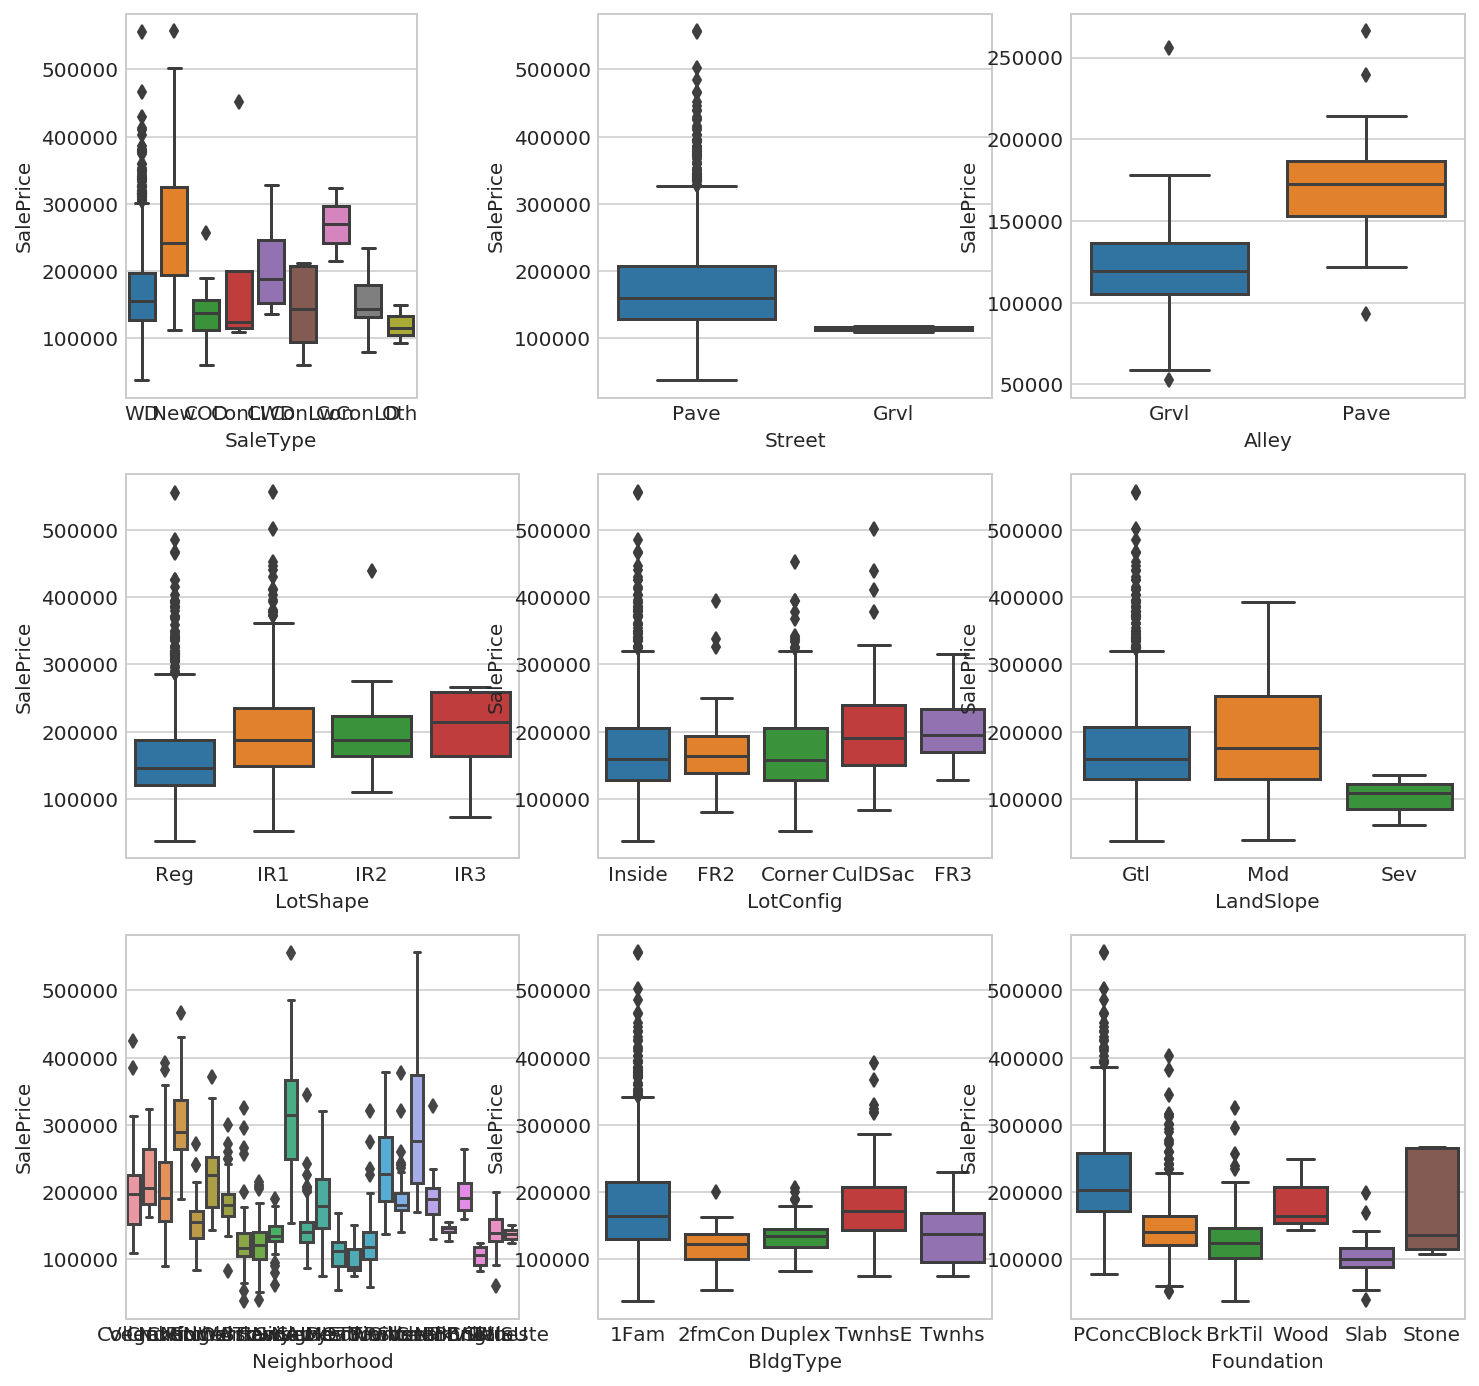

In [9]:
house1.columns
plt.figure(figsize =[12,12])
plt.subplot(331)
sns.boxplot('MSZoning', 'SalePrice', data =house1)
plt.subplot(332)
sns.boxplot('Street', 'SalePrice', data=house1)
plt.subplot(333)
sns.boxplot('Alley', 'SalePrice', data=house1)
plt.subplot(334)
sns.boxplot('LotShape', 'SalePrice', data=house1)
plt.subplot(335)
sns.boxplot('LotConfig','SalePrice', data=house1)
plt.subplot(336)
sns.boxplot('LandSlope', 'SalePrice', data=house1)
plt.subplot(337)
sns.boxplot('Neighborhood', 'SalePrice', data=house1)
plt.subplot(338)
sns.boxplot('BldgType', 'SalePrice', data=house1)
plt.subplot(339)
sns.boxplot('Foundation', 'SalePrice', data=house1)
plt.subplot(341)
sns.boxplot('SaleType', 'SalePrice', data=house1)

### Handling the 'Neighborhood' feature

Visually, we can see that Neighborhood is a pretty good indicator of Sales Price. Neighborhood is a Nominal feature, with 25 different categories.

There are a few ways to handle nominal data.

1. Use one-hot encoding.

2. Group the data into bins. 


I decided to use one-hot encoding.

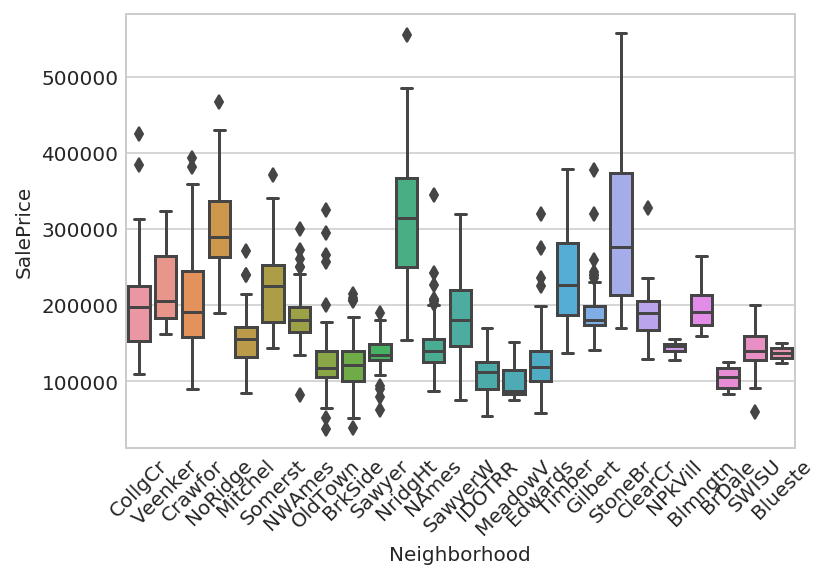

In [10]:
plt.xticks(rotation=45)
sns.boxplot('Neighborhood', 'SalePrice', data=house1)


In [11]:
# Get dummies for the 'Neighborhood' feature.

house_dummies = pd.get_dummies(house1.Neighborhood)
house1 = pd.concat([house1, house_dummies], axis=1)
house1.drop('Neighborhood', axis=1, inplace=True)

###  I decided not to use Street, Alley, LotShape, LotConfig, LandSlope due to low variance in data

In [12]:
to_drop = ['Street','Alley','LotShape','LotConfig','LandSlope']
house1.drop(house1[to_drop], axis=1, inplace=True)

#Drop multiple columns at once by df.drop(df[cols_to_drop]). Interesting!

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape



(162, 57)
(162, 81)


### Let's examine the distribution of each categorical feature. 

In [13]:
newlist = house1.select_dtypes(exclude=['int64', 'float64']).head().columns
newlist = list(newlist)
for i in newlist:
    print house1[i].value_counts()
    


RL    1083
RM     217
FV      65
RH      15
Name: MSZoning, dtype: int64
Lvl    1263
Bnk      56
HLS      42
Low      19
Name: LandContour, dtype: int64
1Fam      1146
TwnhsE     114
Duplex      50
Twnhs       43
2fmCon      27
Name: BldgType, dtype: int64
PConc     620
CBlock    591
BrkTil    139
Slab       22
Stone       5
Wood        3
Name: Foundation, dtype: int64
WD       1202
New       114
COD        38
ConLD       7
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64
0    1363
1      17
Name: Blmngtn, dtype: int64
0    1378
1       2
Name: Blueste, dtype: int64
0    1364
1      16
Name: BrDale, dtype: int64
0    1323
1      57
Name: BrkSide, dtype: int64
0    1365
1      15
Name: ClearCr, dtype: int64
0    1230
1     150
Name: CollgCr, dtype: int64
0    1333
1      47
Name: Crawfor, dtype: int64
0    1284
1      96
Name: Edwards, dtype: int64
0    1306
1      74
Name: Gilbert, dtype: int64
0    1352
1      28
Name: IDOTRR, dtype: i

In [14]:
house1.MSZoning.value_counts()

#Srop BldgType and SaleType, LandContour, and MSZoning because data too imbalanced. 
house1.drop(house1[['BldgType','SaleType', 'LandContour', 'MSZoning']], axis=1, inplace=True)

#Foundation: Take only 2 category PConoc and CBlock. Remaining category merge into PConc. 
house1.Foundation = house1.Foundation.map(lambda x: 'CBlock' if x == 'CBlock' else 'PConc')

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 53)
(162, 81)


### GrLivArea is actually just the sum of 1stFlrSF and 2ndFlrSF. 

Using all of these variables would introduce Multicollinearity, so I decided to only use GrLivArea.

In [15]:
house1.drop('1stFlrSF', axis=1, inplace=True)
house1.drop('2ndFlrSF', axis=1, inplace=True)

SalePrice = house1['SalePrice']
house1.drop('SalePrice', axis=1, inplace=True)
house1.shape
house1['SalePrice'] = SalePrice

### Features that have a lot of missing data are not useful features.

In [16]:
#Drop due to missing data.
#house1.drop('LotFrontage', axis=1, inplace=True)
house1.drop('3SsnPorch', axis=1, inplace=True)
house1.drop('ScreenPorch', axis=1, inplace=True)
house1.drop('PoolArea', axis=1, inplace=True)
house1.drop('MiscVal', axis=1, inplace=True)

#OpenPorchSF and WoodDeckSF a bit too many missing values. Got to get rid of them as well.
house1.drop('OpenPorchSF', axis=1, inplace=True)
house1.drop('WoodDeckSF', axis=1, inplace=True)

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape




(162, 45)
(162, 81)


In [17]:
house1.drop('LotFrontage',axis=1,inplace=True)

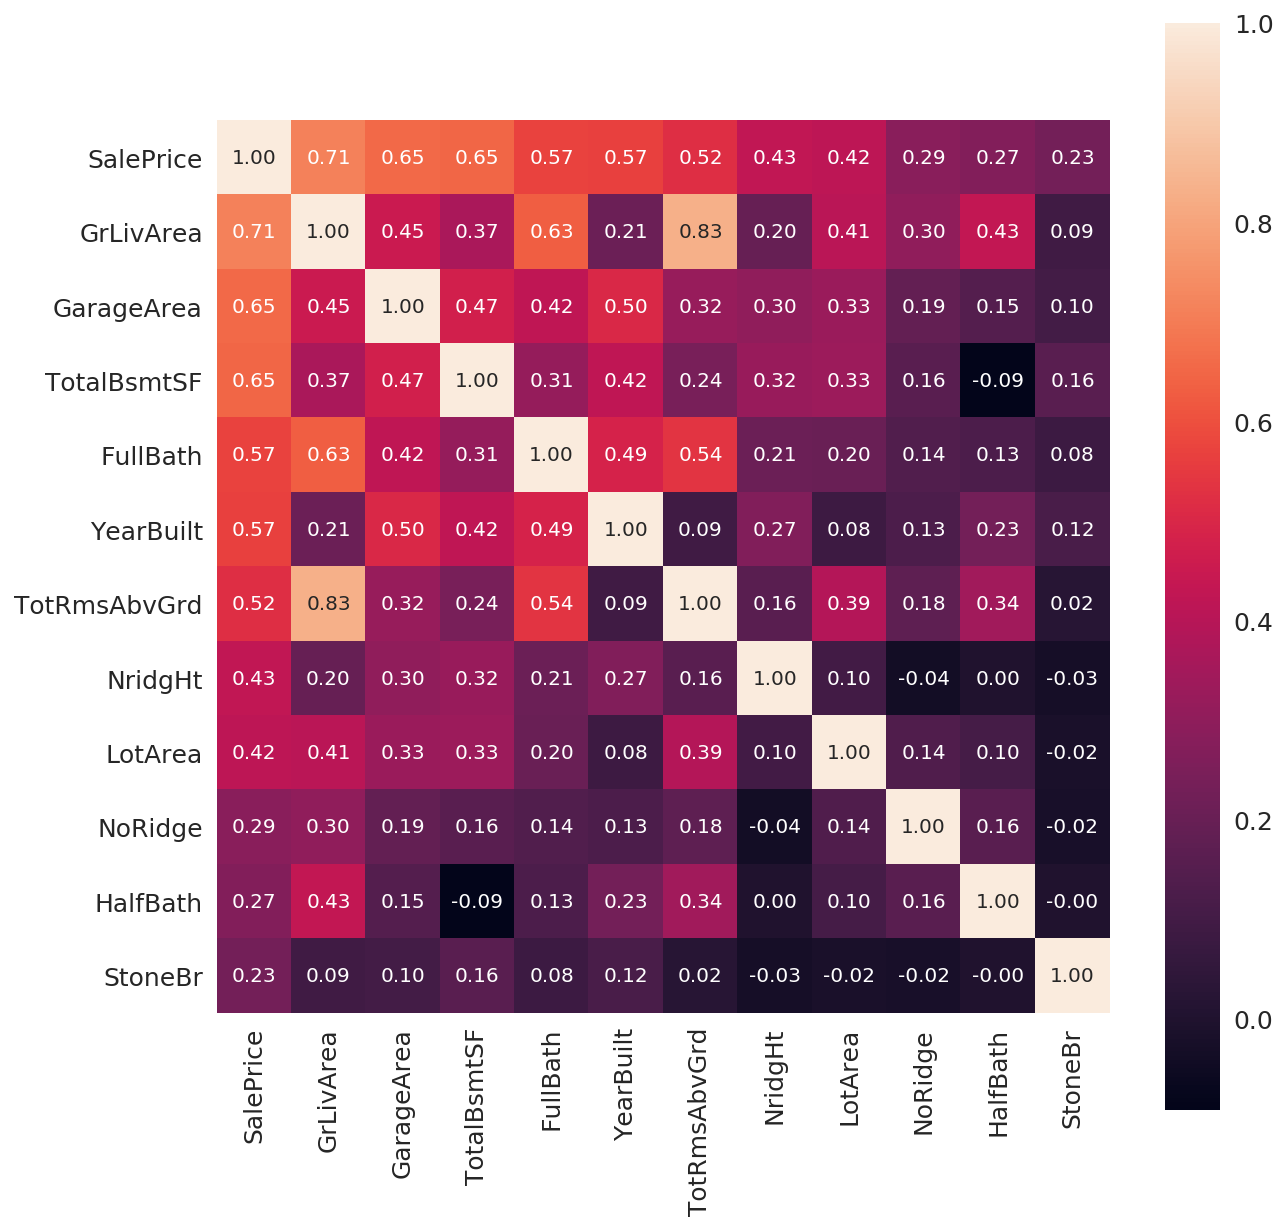

In [18]:
k = 12 #number of variables for heatmap
plt.figure(figsize=(10,10))
corrmat = house1.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house1[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


In [19]:
#TotalRmsAbvGrd and GrLivArea very correlated. Drop TotalRmsAbvGrd.
#1stFlrSF and TotalBsmtSF very correlated. Drop TotalBsmtSF as it has some missing values.

house1.drop('TotRmsAbvGrd', axis=1, inplace=True)
house1.drop('TotalBsmtSF', axis=1,inplace=True)

#get_dummies for foundation
found = pd.get_dummies(house1.Foundation)
house1 = pd.concat([house1, found], axis=1)

house1.drop('Foundation', axis=1, inplace=True)
house1.drop('CBlock', axis=1, inplace=True)

house1.drop('Id', axis=1, inplace=True)

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 41)
(162, 81)


<div style="width:700px;background:#F9EECF;border:1px solid black;text-align:center;padding:8px;">


<b style="font-size:18pt">Creating prediction models</b>
<br>

</div>


Our task is to train a prediction model on pre-2010 data, and to test our model on 2010 data.

In [20]:
train = house1[house1['YrSold'] != 2010]
test = house1[house1['YrSold'] == 2010]

X_train = train.loc[:,train.columns != 'SalePrice'] #all cols except SalesPrice
 
y_train = train['SalePrice']

X_test = test.loc[:,test.columns != 'SalePrice']

y_test = test['SalePrice']

#StandardScalar on  x_train, x_test
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs_train = ss.fit_transform(X_train, y_train)
Xs_test = ss.fit_transform(X_test, y_test)

In [21]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 41)
(162, 81)


In [22]:
np.set_printoptions(suppress=True, precision=5,
   formatter={'float_kind':'{:f}'.format})


#Trying with Linear Regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(Xs_train, y_train)

print linreg.coef_

y_pred = linreg.predict(Xs_test)

print 'The root mean squared error for linear regression model is ' + str(np.sqrt(mean_squared_error(y_test, y_pred)))

print 'The R2 score for linear regression model is ' + str(linreg.score(Xs_test, y_test) )

[-8450.928391 8425.189710 21955.269184 40544.869354 9257.089227 3555.705658
 778.852421 -2183.218452 -7676.339029 -4435.735382 6327.601528 1033.150393
 858.236908 238.702793 17063097133597320.000000 6067746426993984.000000
 16528143739142932.000000 31118369979317460.000000 15399649542792822.000000
 47349867543657440.000000 27964433417667368.000000 38183000721055672.000000
 34407174847260868.000000 21248871200631032.000000 15974339095724264.000000
 26708425025763356.000000 53906602209369480.000000 11328351851548040.000000
 33189973429684600.000000 22459399188130664.000000 33926873947530316.000000
 40572737515598704.000000 19958255044480764.000000 31386487458589828.000000
 27964433417658364.000000 36469837035756136.000000 19045353796360564.000000
 22459399188128132.000000 13523188603343032.000000 2384.533432]
The root mean squared error for linear regression model is 3.20692848678e+16
The R2 score for linear regression model is -2.21235307545e+23


In [23]:
#Trying with linreg, without scaling
# r2 score = .8583

linreg.fit(X_train, y_train)
print linreg.coef_
y_pred = linreg.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))
print linreg.score(X_test, y_test)

print 'The root mean squared error for linear regression model is ' +str(np.sqrt(mean_squared_error(y_test, y_pred)))
print 'The R2 score for linear regression model is ' +str(linreg.score(X_test, y_test))

[-200.849813 2.527313 722.102161 84.679370 18245.914532 14417.084914
 1417.622173 -4309.607576 -9512.927129 -20459.811508 29.963964 17.328374
 317.328026 220.149573 7009.748862 -1875.736066 3930.842516 3602.340367
 -25380.285275 -13098.090445 26630.210567 -19819.185757 -20795.390056
 -1505.121539 -7830.498836 -23288.931736 -14377.100911 15130.131692
 -21361.037371 15882.701038 51202.161756 -7196.726646 -10555.943382
 -20705.799883 -21683.200423 10119.176159 62516.561937 -1047.048266
 14496.221697 4849.194667]
0.85834766785
The root mean squared error for linear regression model is 25661.0203329
The R2 score for linear regression model is 0.85834766785


### Lets take a look into which features were the most important in our linear regression model.

In [24]:
coefficients = pd.DataFrame({"Feature":X_train.columns,"Coefficients":np.transpose(linreg.coef_)})

coefficients

Coefficients        Feature
0    -200.849813     MSSubClass
1       2.527313        LotArea
2     722.102161      YearBuilt
3      84.679370      GrLivArea
4   18245.914532   BsmtFullBath
5   14417.084914   BsmtHalfBath
6    1417.622173       FullBath
7   -4309.607576       HalfBath
8   -9512.927129   BedroomAbvGr
9  -20459.811508   KitchenAbvGr
10     29.963964     GarageArea
11     17.328374  EnclosedPorch
12    317.328026         MoSold
13    220.149573         YrSold
14   7009.748862        Blmngtn
15  -1875.736066        Blueste
16   3930.842516         BrDale
17   3602.340367        BrkSide
18 -25380.285275        ClearCr
19 -13098.090445        CollgCr
20  26630.210567        Crawfor
21 -19819.185757        Edwards
22 -20795.390056        Gilbert
23  -1505.121539         IDOTRR
24  -7830.498836        MeadowV
25 -23288.931736        Mitchel
26 -14377.100911          NAmes
27  15130.131692        NPkVill
28 -21361.037371         NWAmes
29  15882.701038        NoRidge
30  51202.161756        NridgHt
31  -7196.726646        OldTown
32 -10555.943382          SWISU
33 -20705.799883         Sawyer
34 -21683.200423        SawyerW
35  10119.176159        Somerst
36  62516.561937        StoneBr
37  -1047.048266         Timber
38  14496.221697        Veenker
39   4849.194667          PConc

In [25]:
print linreg.coef_.shape
print house1.shape

(40,)
(1380, 41)


### Let's try using Elastic Net. 

A quick revision on Lasso and Ridge regression:


* Lasso does a sparse selection, while Ridge does not.

* When you have highly-correlated variables, Ridge regression shrinks the two coefficients towards one another. Lasso is somewhat indifferent and generally picks one over the other. Depending on the context, one does not know which variable gets picked. Elastic-net is a compromise between the two that attempts to shrink and do a sparse selection simultaneously.

* Ridge estimators are indifferent to multiplicative scaling of the data. That is, if both X and Y variables are multiplied by constants, the coefficients of the fit do not change, for a given λλ parameter. However, for Lasso, the fit is not independent of the scaling. In fact, the λλ parameter must be scaled up by the multiplier to get the same result. It is more complex for elastic net.

* Ridge penalizes the largest ββ's more than it penalizes the smaller ones (as they are squared in the penalty term). Lasso penalizes them more uniformly. This may or may not be important. In a forecasting problem with a powerful predictor, the predictor's effectiveness is shrunk by the Ridge as compared to the Lasso.



Elasticnet is introduced as a compromise between these two techniques, and has a penalty which is a mix of L1L1 and L2L2 norms.



In [26]:
#Trying with ElasticNet. Hyperparameters were decided after experimentation.

enet = ElasticNet(alpha=0.1, l1_ratio=0.5)

enet.fit(X_train, y_train)

print enet.coef_
y_pred = enet.predict(X_test)

from sklearn import metrics
print 'The root mean squared error for my elasticnet model is ' +str( np.sqrt(mean_squared_error(y_test, y_pred)))
print 'R2 score is ' +str(enet.score(X_test, y_test))

[-176.101809 2.119722 795.519784 94.271547 13556.574873 5846.572052
 -1132.762082 -5730.237155 -13031.873140 -11863.014644 43.011122 22.020994
 627.729410 -96.546082 -3.031018 -78.226398 1240.165669 4605.962951
 -3758.733133 -8446.257844 12836.363143 -6486.016633 -10384.958300
 1593.290036 -866.435748 -7426.899214 -5332.626954 1825.126290 -8074.072607
 3306.952898 23236.845843 -2394.764404 -1020.112795 -5904.459997
 -8309.289365 3249.203173 14013.239542 9.393186 2572.341678 7009.814181]
The root mean squared error for my elasticnet model is 26075.1416316
R2 score is 0.853738763849


### How does ElasticNet and Linear Regression differ? 

ElasticNet imposes a penalty term on large coefficients to prevent overfitting. Let's look at the difference in the weight of the coefficients between our Linear Regression and ElasticNet models.

In [27]:


coefficients = pd.DataFrame({"Feature":X_train.columns,"Enet Coefficients":np.transpose(enet.coef_), "LinReg Coefficients":np.transpose(linreg.coef_)}).astype(object)

coefficients

Enet Coefficients        Feature LinReg Coefficients
0           -176.102     MSSubClass             -200.85
1            2.11972        LotArea             2.52731
2             795.52      YearBuilt             722.102
3            94.2715      GrLivArea             84.6794
4            13556.6   BsmtFullBath             18245.9
5            5846.57   BsmtHalfBath             14417.1
6           -1132.76       FullBath             1417.62
7           -5730.24       HalfBath            -4309.61
8           -13031.9   BedroomAbvGr            -9512.93
9             -11863   KitchenAbvGr            -20459.8
10           43.0111     GarageArea              29.964
11            22.021  EnclosedPorch             17.3284
12           627.729         MoSold             317.328
13          -96.5461         YrSold              220.15
14          -3.03102        Blmngtn             7009.75
15          -78.2264        Blueste            -1875.74
16           1240.17         BrDale             3930.84
17           4605.96        BrkSide             3602.34
18          -3758.73        ClearCr            -25380.3
19          -8446.26        CollgCr            -13098.1
20           12836.4        Crawfor             26630.2
21          -6486.02        Edwards            -19819.2
22            -10385        Gilbert            -20795.4
23           1593.29         IDOTRR            -1505.12
24          -866.436        MeadowV             -7830.5
25           -7426.9        Mitchel            -23288.9
26          -5332.63          NAmes            -14377.1
27           1825.13        NPkVill             15130.1
28          -8074.07         NWAmes              -21361
29           3306.95        NoRidge             15882.7
30           23236.8        NridgHt             51202.2
31          -2394.76        OldTown            -7196.73
32          -1020.11          SWISU            -10555.9
33          -5904.46         Sawyer            -20705.8
34          -8309.29        SawyerW            -21683.2
35            3249.2        Somerst             10119.2
36           14013.2        StoneBr             62516.6
37           9.39319         Timber            -1047.05
38           2572.34        Veenker             14496.2
39           7009.81          PConc             4849.19

### And finally, gradient boosting.

Using the xgboost package by Tianqi Chen. Gradient boosting has better R2 scores than our linear regression or elasticnet models.

I also compared sklearn's gridsearch against a very Python for-loop to search for optimal hyperparameters.

In [28]:
# Using xgboost

from xgboost import XGBRegressor

model = XGBRegressor(seed=42, learning_rate=0.5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

y_hat = model.predict(X_test) #this is the y_hat to use for question 2

residuals = y_hat - y_test

numbers = np.linspace(0, 1, 100)

tracker = {}

# A very simple gridsearch on XGBRegressor's learning rate
for i in numbers:
    model = model = XGBRegressor(seed=42, learning_rate=i)
    model.fit(X_train, y_train)
    scores = model.score(X_test, y_test)
    #print 'learning rate of ' + str(i) + ' and our score is ' +  str(scores)
    tracker[i] = scores

scores_xgboost = pd.DataFrame.from_dict(tracker, orient='index')
scores_xgboost.rename(index=str, columns={0:'XGboost score'}, inplace=True)
scores_xgboost.sort_values('XGboost score', ascending=False).head()


/home/james/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGboost score
0.272727272727       0.892601
0.282828282828       0.888744
0.212121212121       0.888229
0.292929292929       0.883437
0.111111111111       0.881606

In [29]:
#Try gridsearch xgboost 

from sklearn.model_selection import GridSearchCV

xg_params = {'learning_rate': [0.1, 0.2, 0.3], 
            'max_depth' : [1, 2, 3, 4, 5, 6],
            'n_estimators': [100, 500]}
xg_gridsearch = GridSearchCV(XGBRegressor(), xg_params, cv=2, verbose=1)
xg_gridsearch.fit(X_train, y_train)
print 'gridsearching: best score'
print xg_gridsearch.best_score_
print 'gridsearch best params'
print xg_gridsearch.best_params_
best_xg = xg_gridsearch.best_estimator_
best_xg.score(X_test, y_test)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
gridsearching: best score
0.845109954399
gridsearch best params
{'n_estimators': 500, 'learning_rate': 0.2, 'max_depth': 1}


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   16.8s finished


0.87616413885856648

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### In part 1, we only used non-renovatable features.

Now, we use only renovatable features.


In [30]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 41)
(162, 81)


In [31]:
house2.columns

unfixed = [u'Utilities',u'Condition1',u'Condition2',u'HouseStyle',u'OverallQual',u'OverallCond',u'RoofStyle',u'RoofMatl'
          ,u'Exterior1st',u'Exterior2nd',u'ExterQual',u'ExterCond',u'BsmtQual',u'BsmtCond',u'BsmtExposure',u'BsmtFinType1',
          u'Heating',u'HeatingQC',u'CentralAir', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'YrSold'
          ]

house2 = house2[unfixed]
house2.columns
house2['SalePrice'] = house1['SalePrice']

print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 41)
(162, 26)


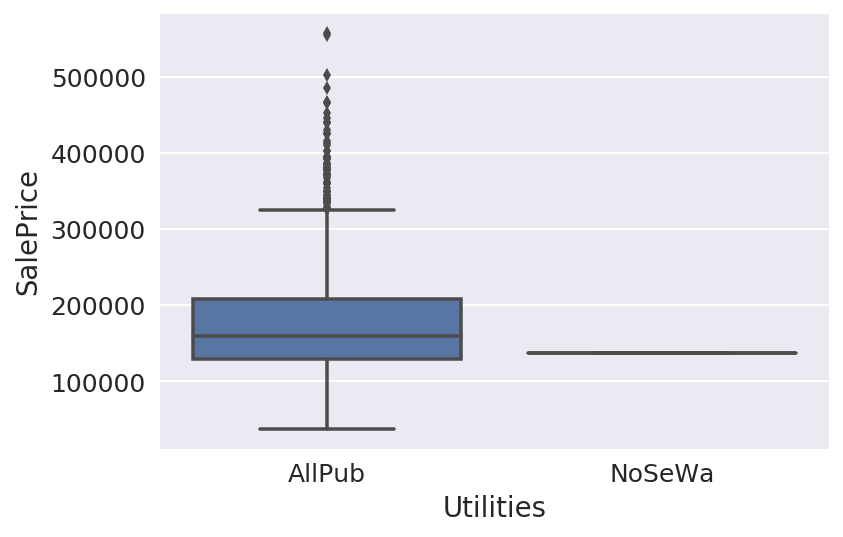

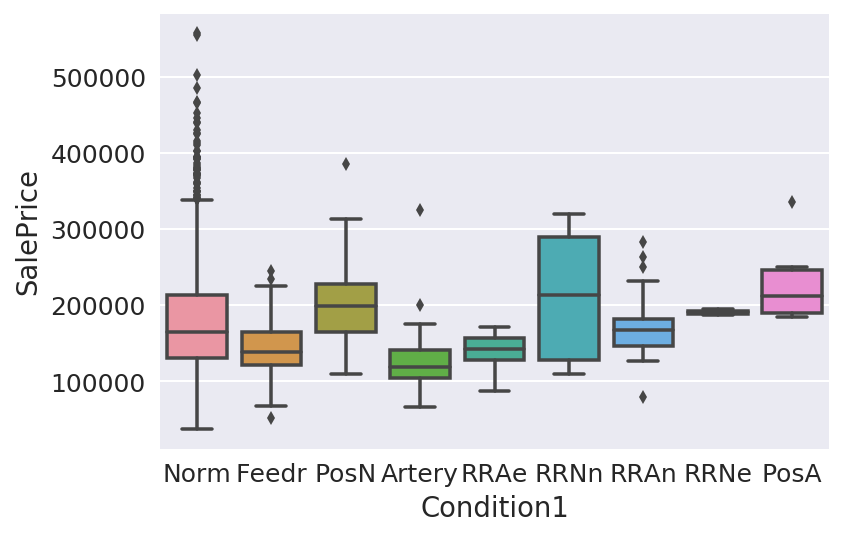

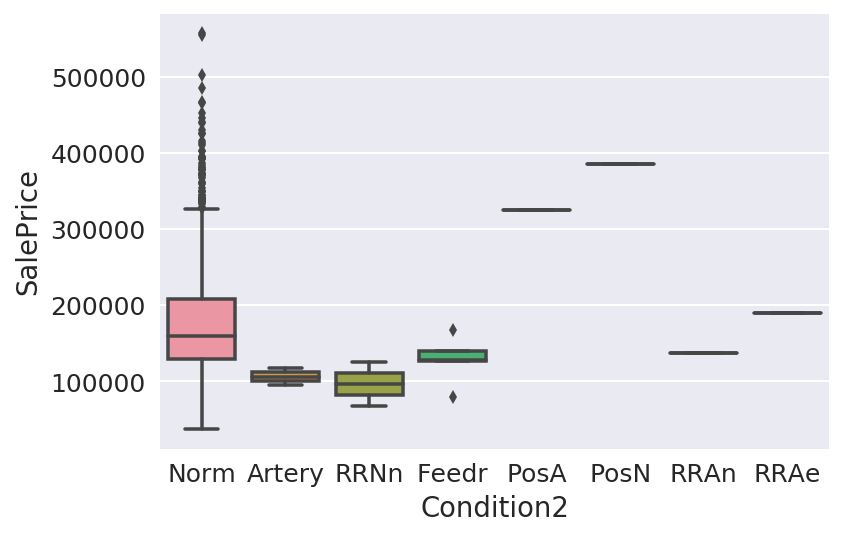

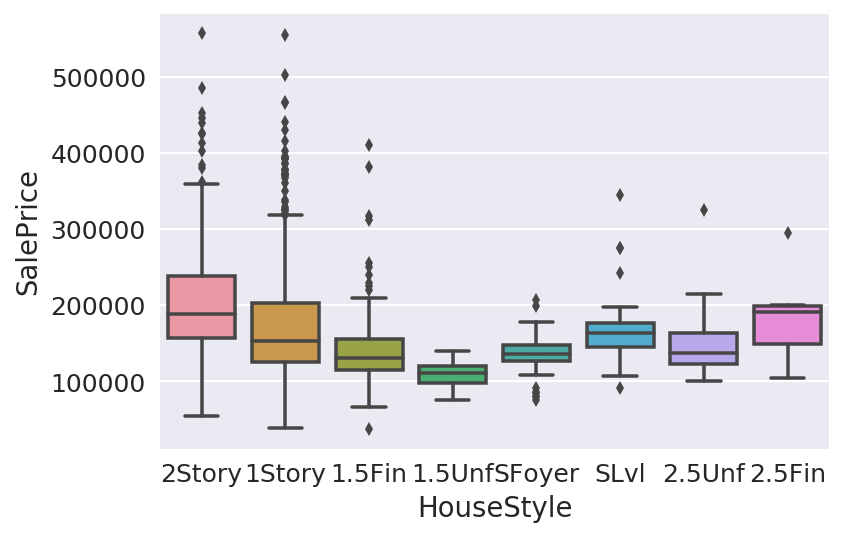

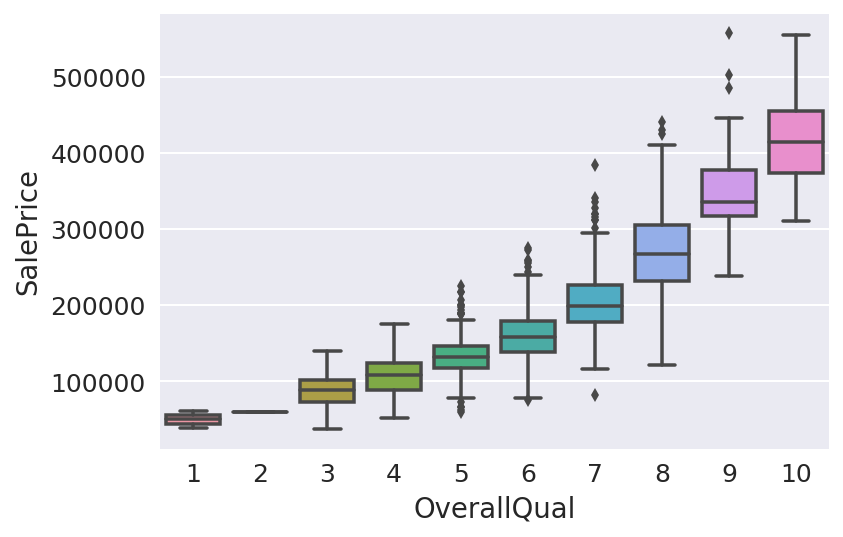

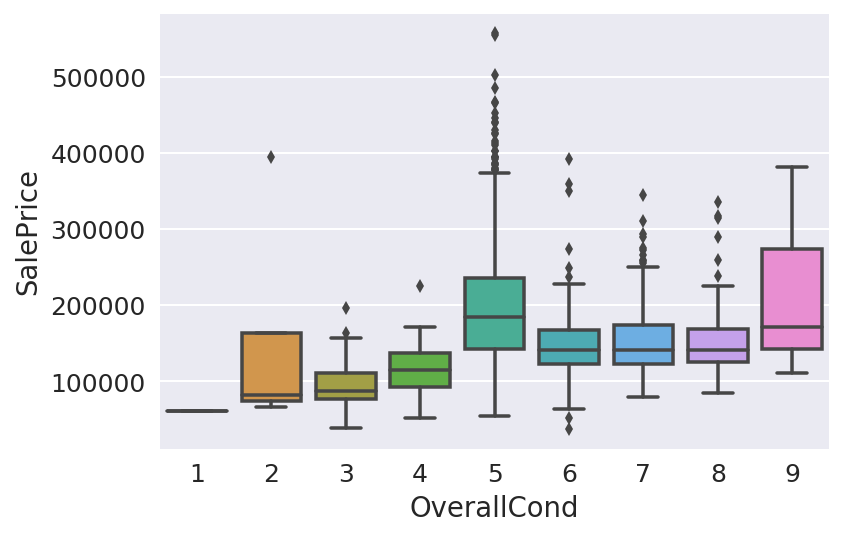

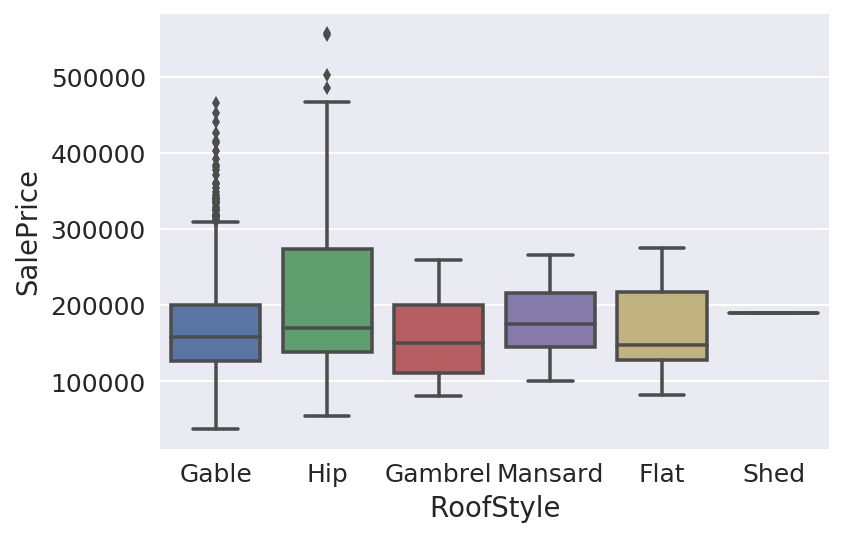

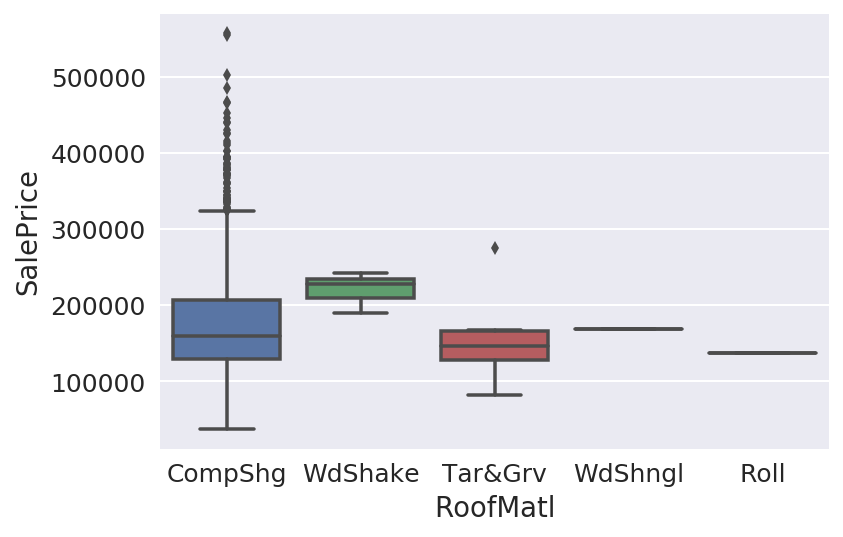

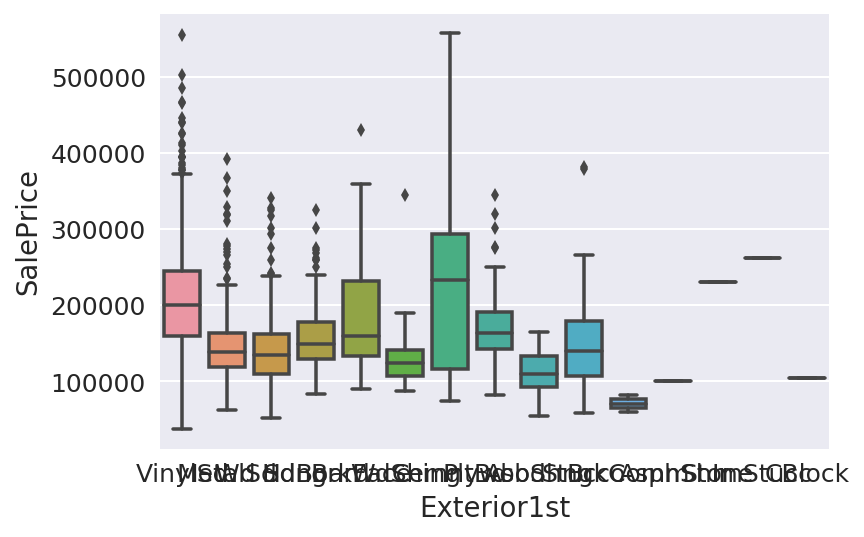

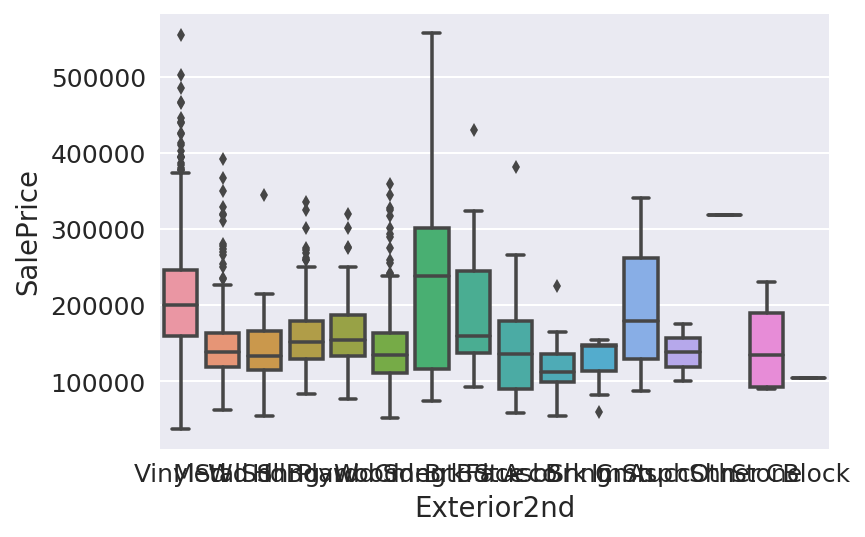

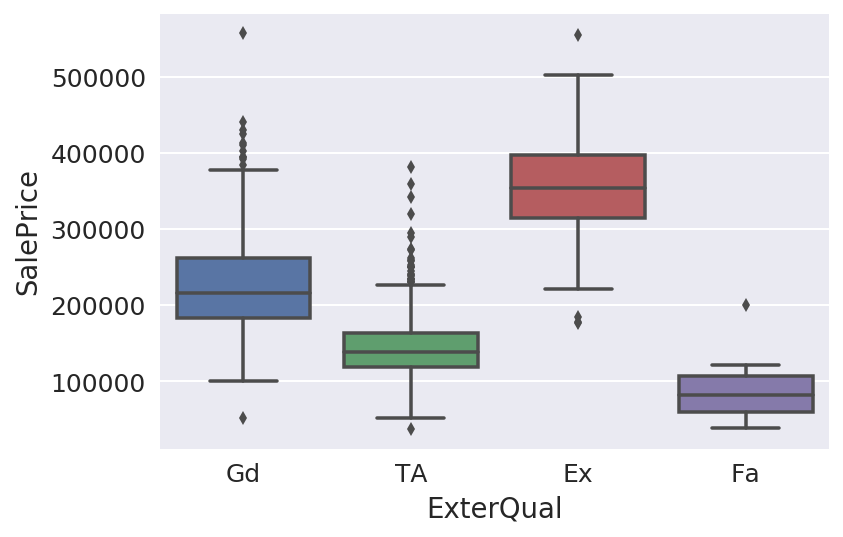

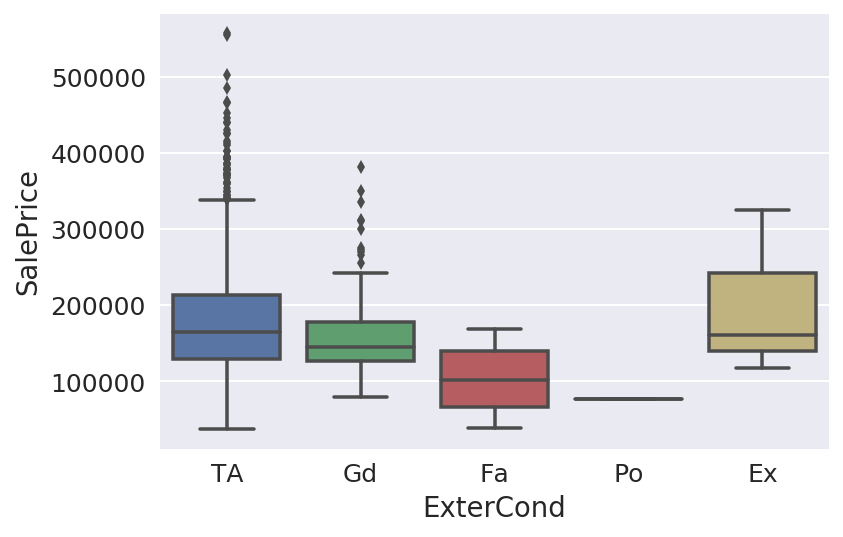

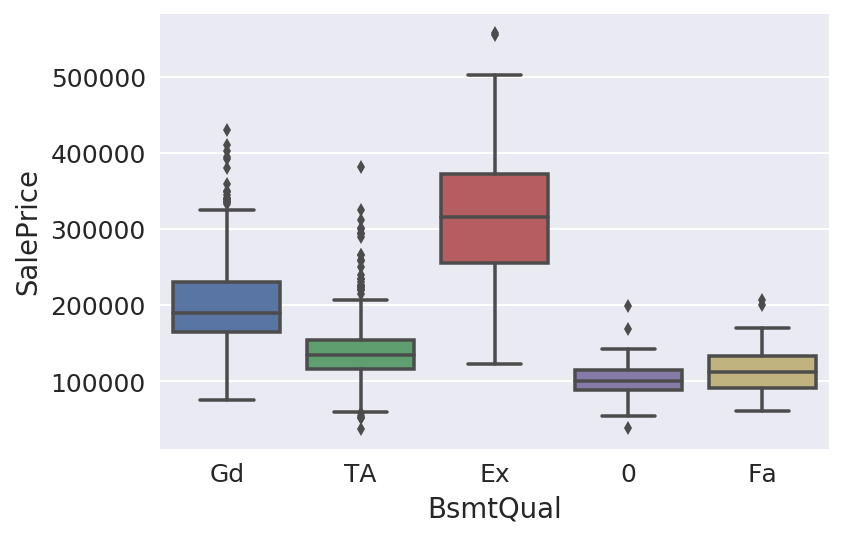

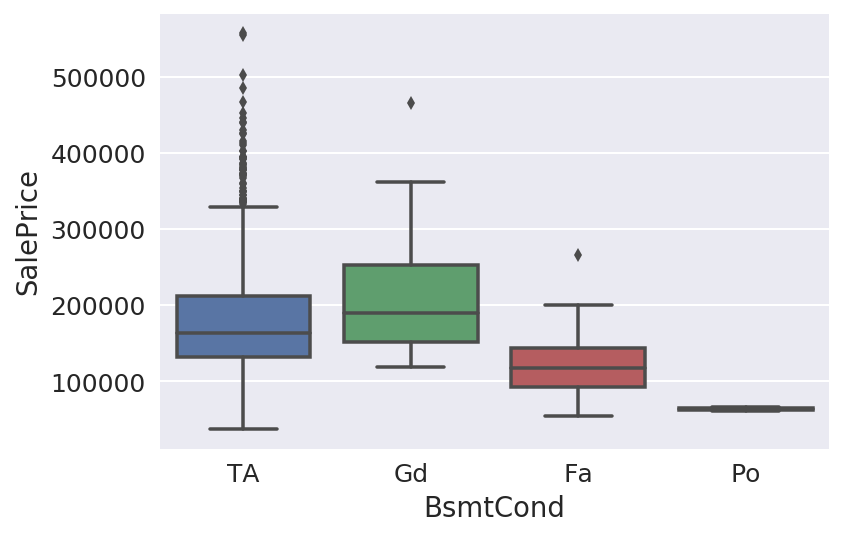

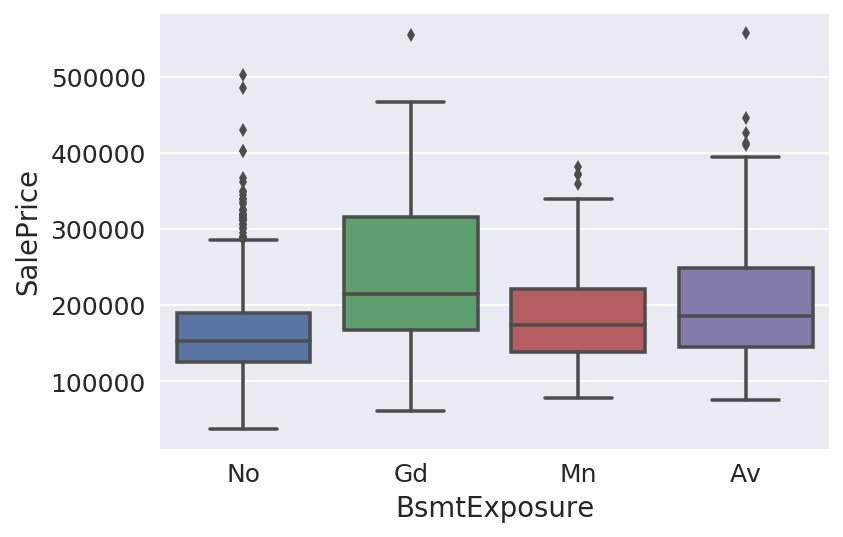

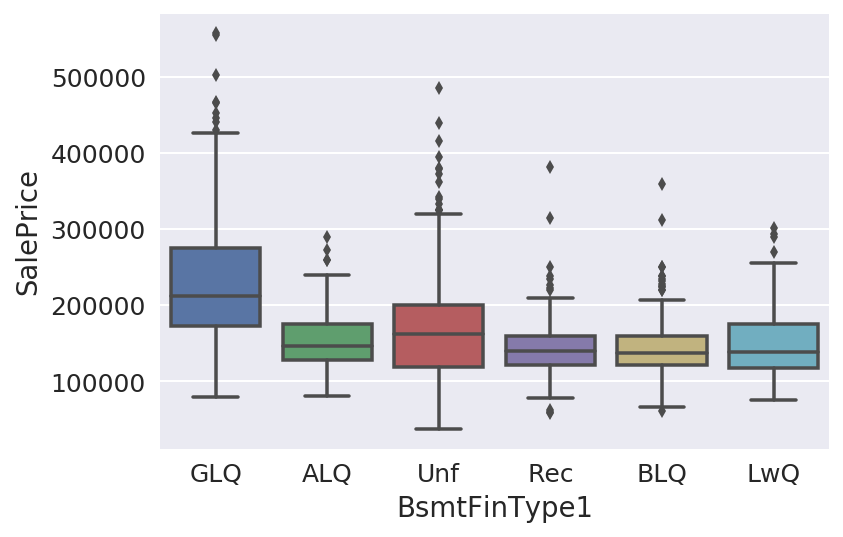

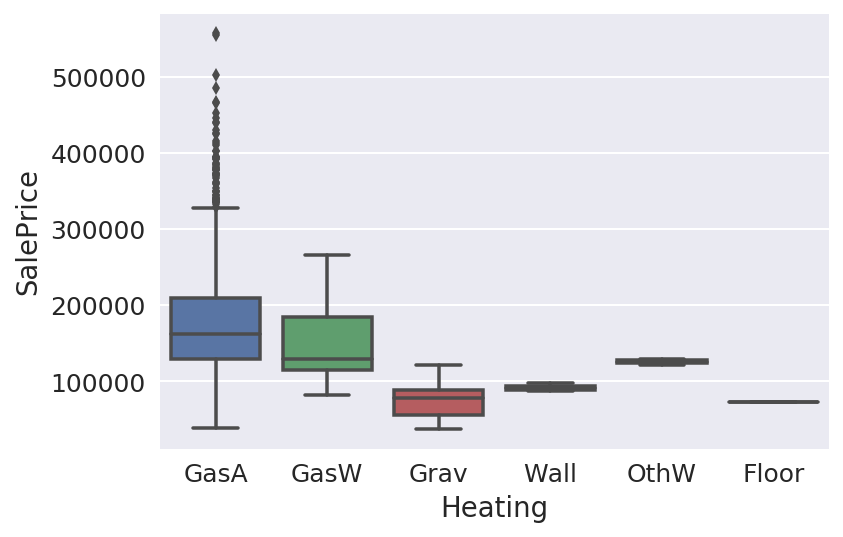

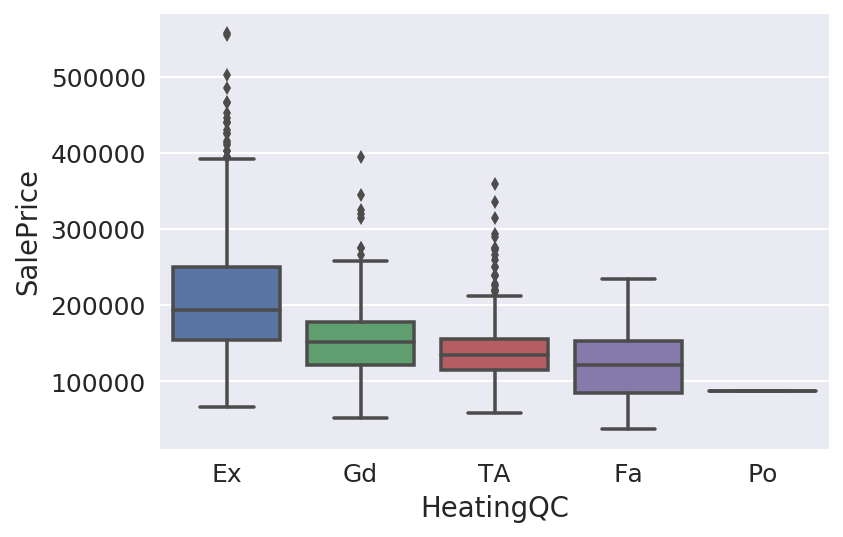

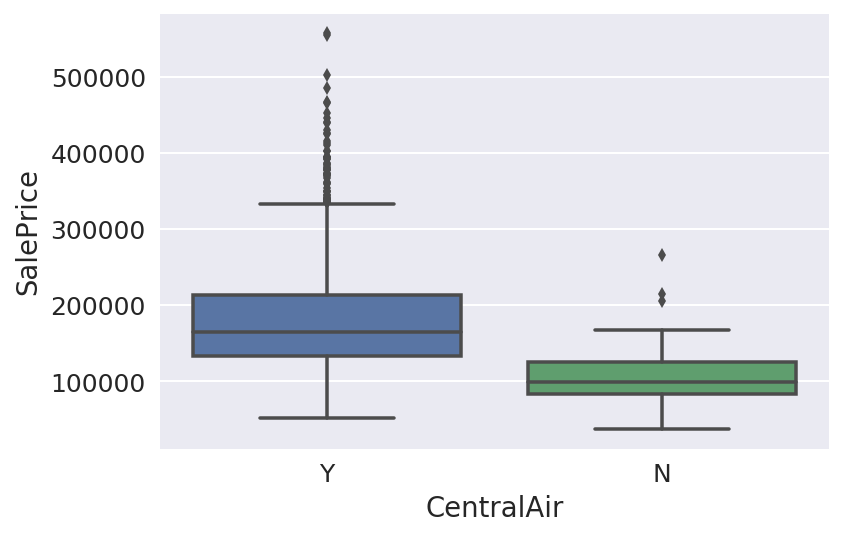

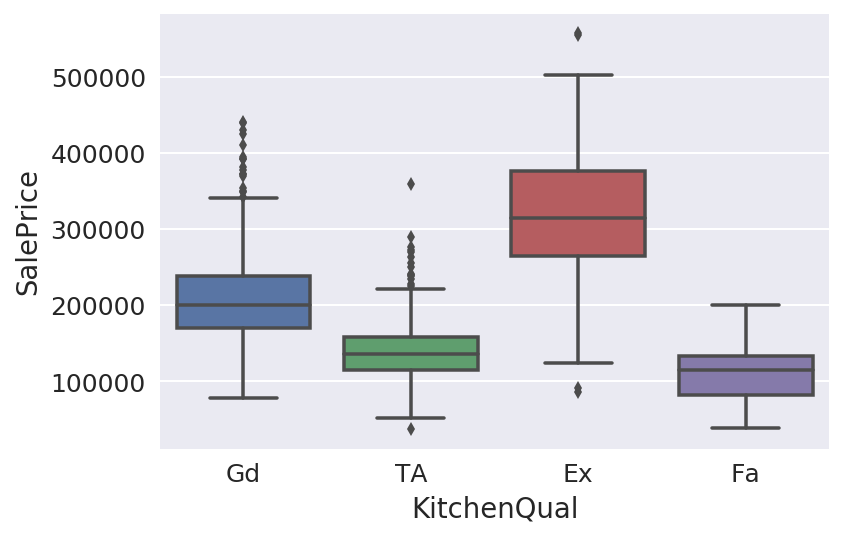

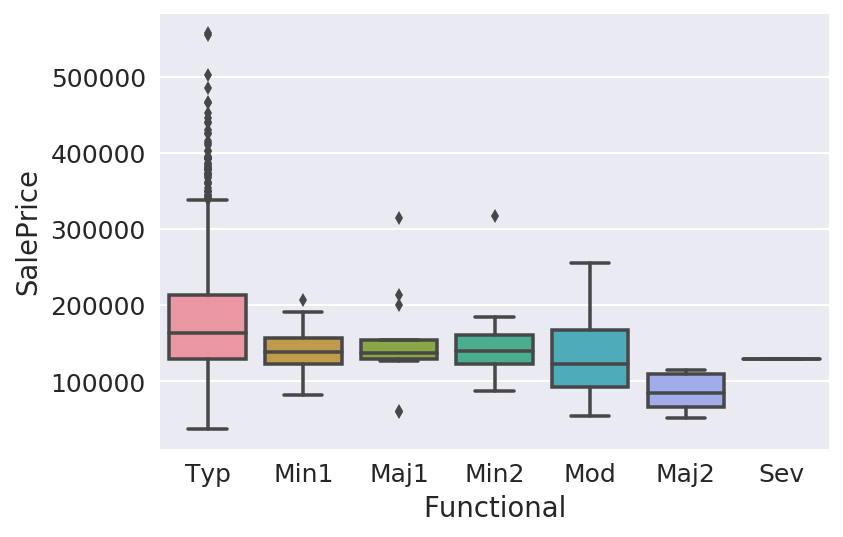

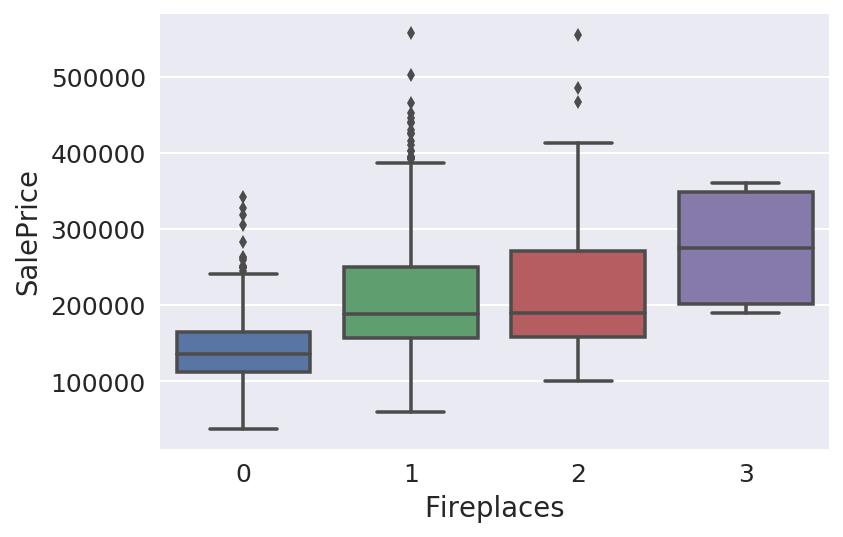

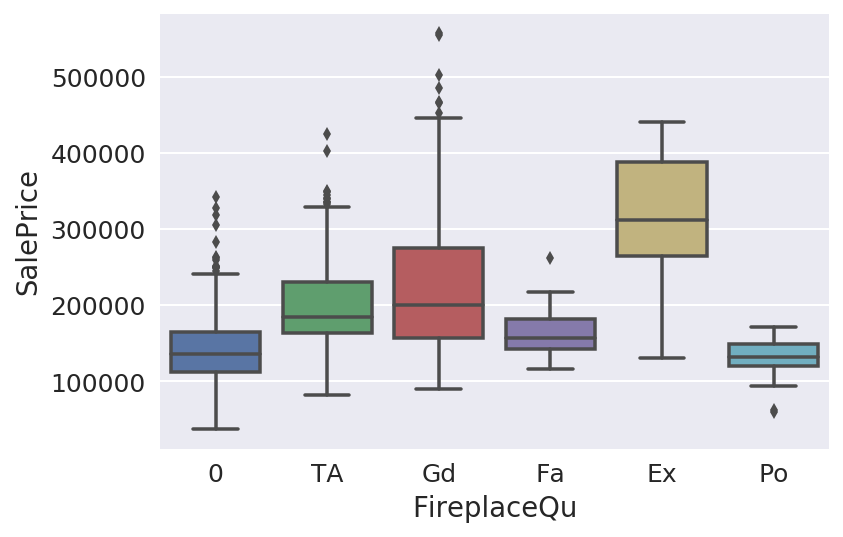

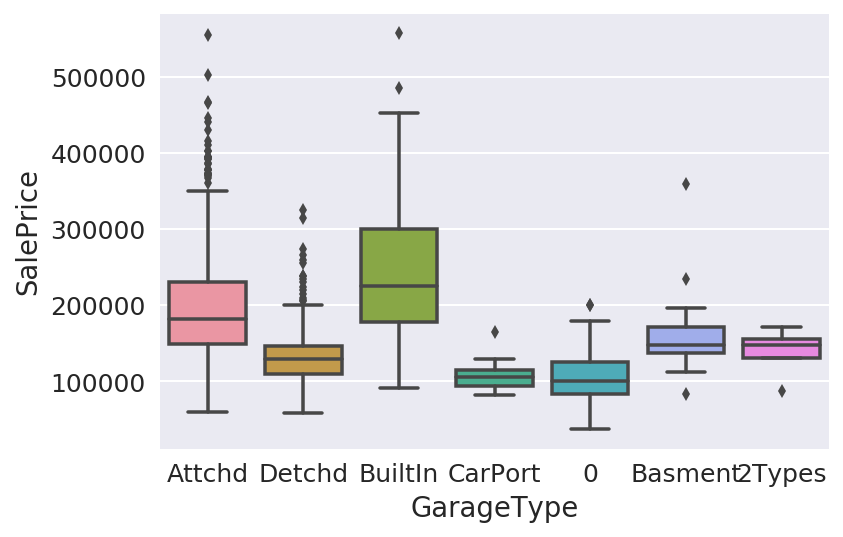

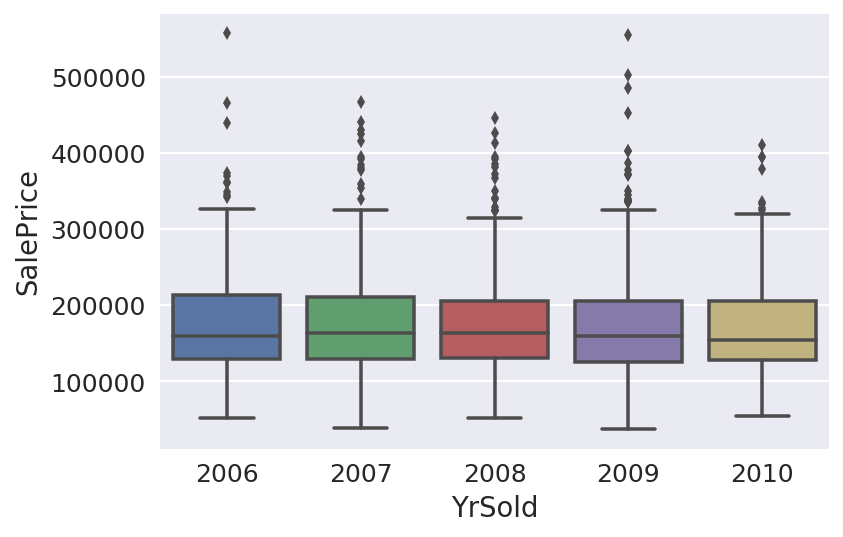

In [32]:

#Find null and missing values.
house2.isnull().sum()
house2.BsmtQual.fillna(0, inplace=True)
house2.FireplaceQu.fillna(0, inplace=True)
house2.GarageType.fillna(0, inplace=True)
house2.isnull().sum()

#sns.lmplot(house2.OverallQual, house2.SalePrice, data=house2, hue='Utilities')
plt.show()
for i in unfixed:
    sns.boxplot(i, 'SalePrice', data=house2)
    plt.show()


In [33]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 41)
(162, 26)


In [34]:
to_drop= ['Utilities', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' ]
house2.drop(to_drop, axis=1, inplace=True)
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 41)
(162, 16)


In [35]:
#All feature modification goes here
house2['HouseStyle'] = house2['HouseStyle'].map(lambda x: 'Other' if x == 'SFoyer' else x)
house2['HouseStyle'] = house2['HouseStyle'].map(lambda x: 'Other' if x == '1.5Unf' else x)
house2['HouseStyle'] = house2['HouseStyle'].map(lambda x: 'Other' if x == '2.5Unf' else x)
house2['HouseStyle'] = house2['HouseStyle'].map(lambda x: 'Other' if x == '2.5Fin' else x)

house2.ExterCond.value_counts()
#house2.drop(house2.loc['ExterCond'] == 'Ex', inplace=True)
house2.ExterCond.value_counts()


print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 41)
(162, 16)


In [36]:
temp = pd.get_dummies(house2.HouseStyle, prefix='HouseStyle')
house2 = pd.concat([house2, temp], axis=1,)
house2.drop('HouseStyle', axis=1, inplace=True)

temp = pd.get_dummies(house2.ExterCond, prefix='ExterCond')
house2 = pd.concat([house2, temp], axis=1)
house2.drop('ExterCond', axis=1, inplace=True)

to_get_dumb = ['CentralAir', 'KitchenQual', 'Fireplaces', 'Functional', 'HeatingQC', 'ExterQual', 'BsmtQual', 
              'Heating', 'FireplaceQu', 'GarageType']
for i in to_get_dumb:
    temp = pd.get_dummies(house2[i], prefix = i)
    house2 = pd.concat([house2, temp], axis=1)
    house2.drop(i, axis=1, inplace=True)

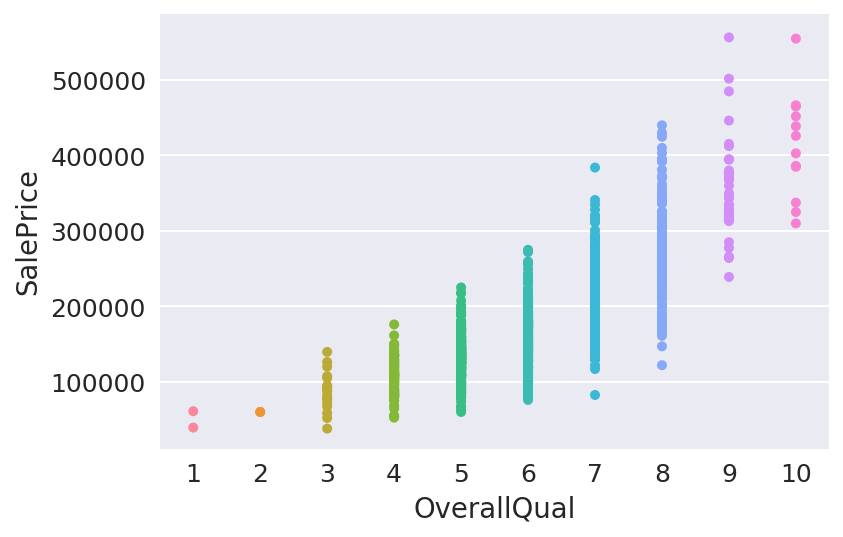

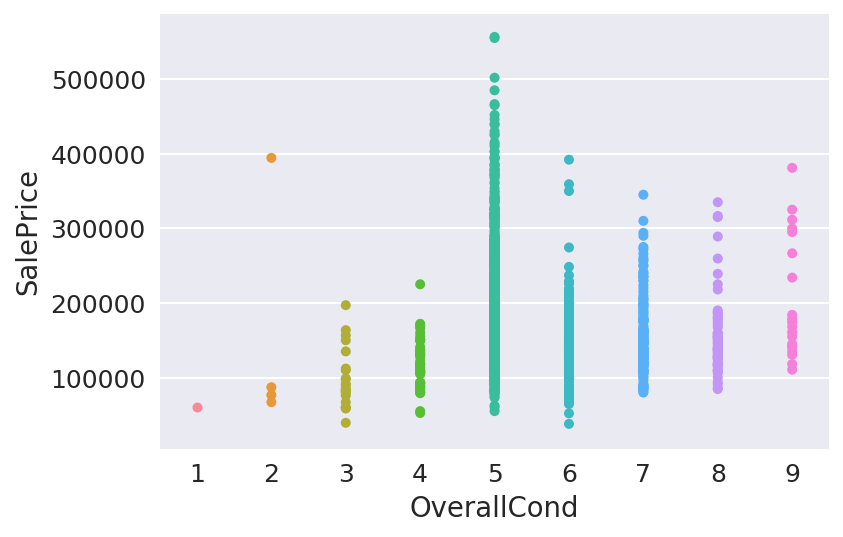

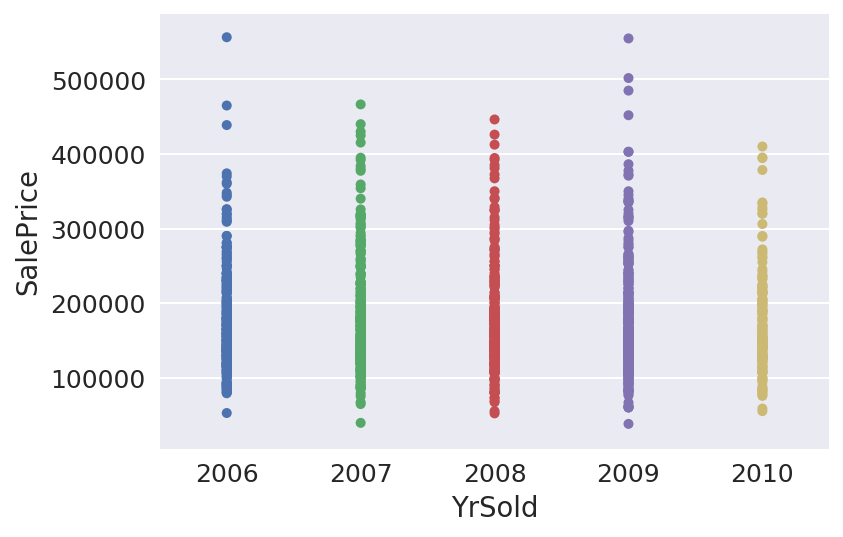

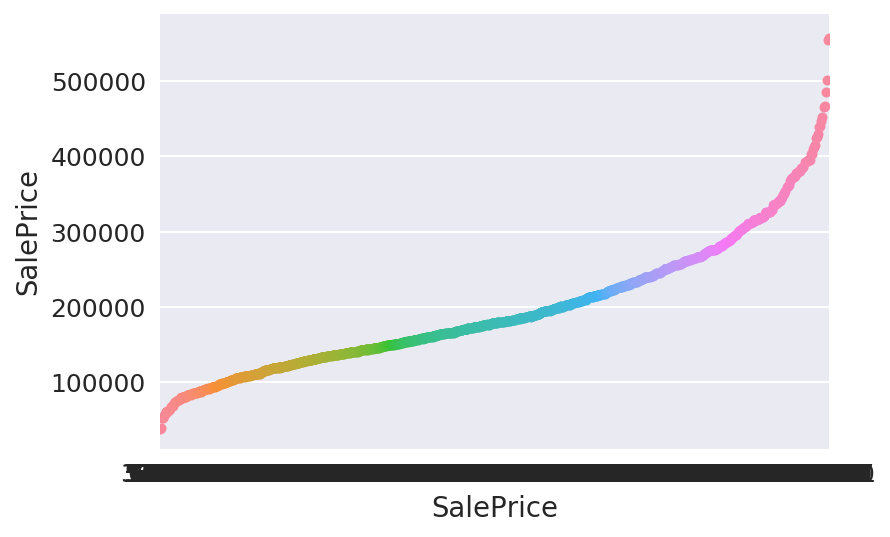

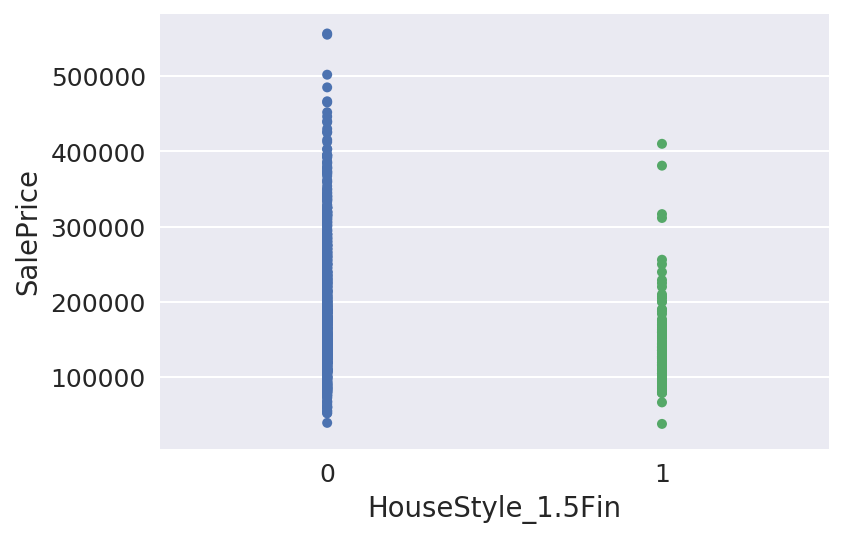

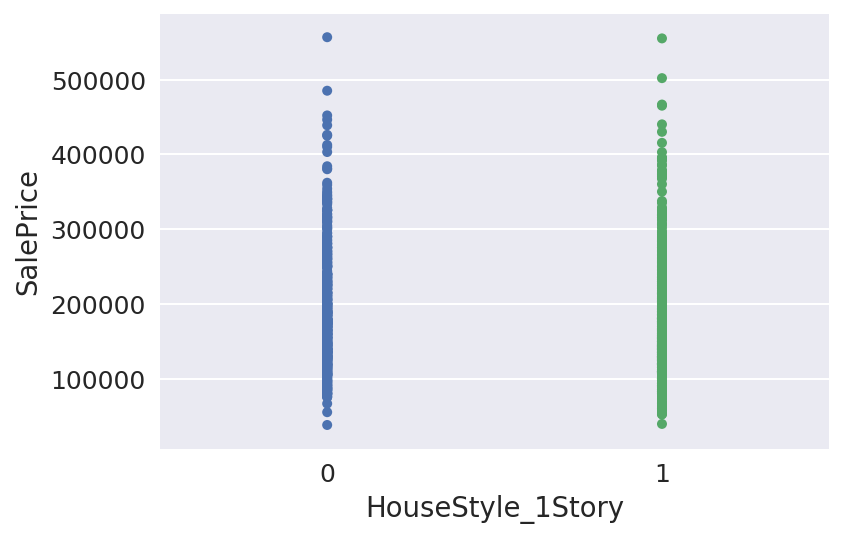

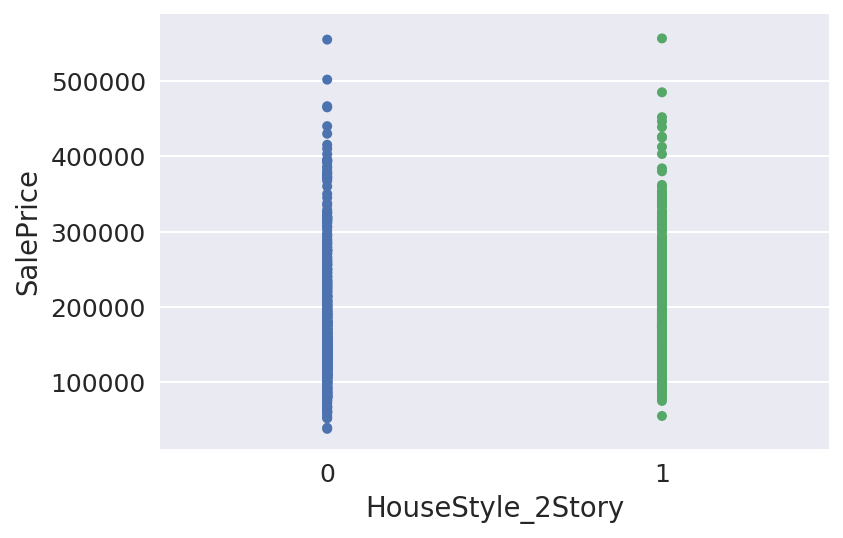

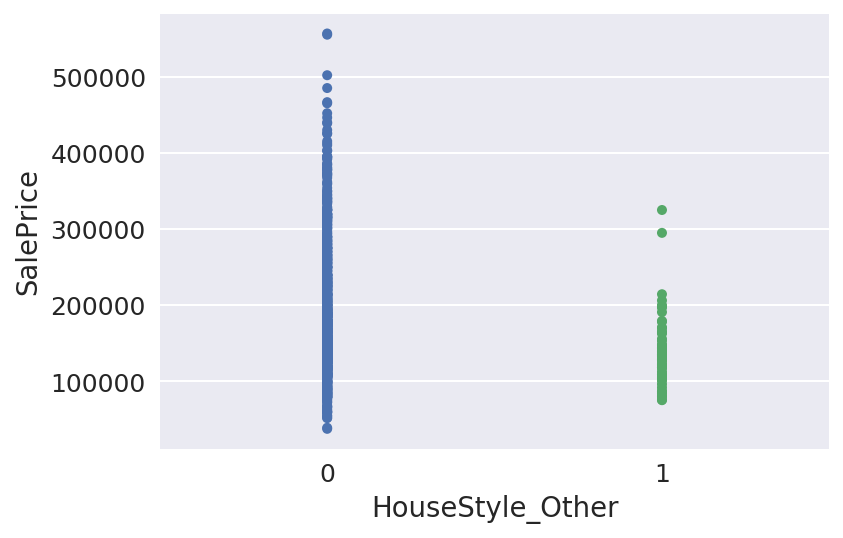

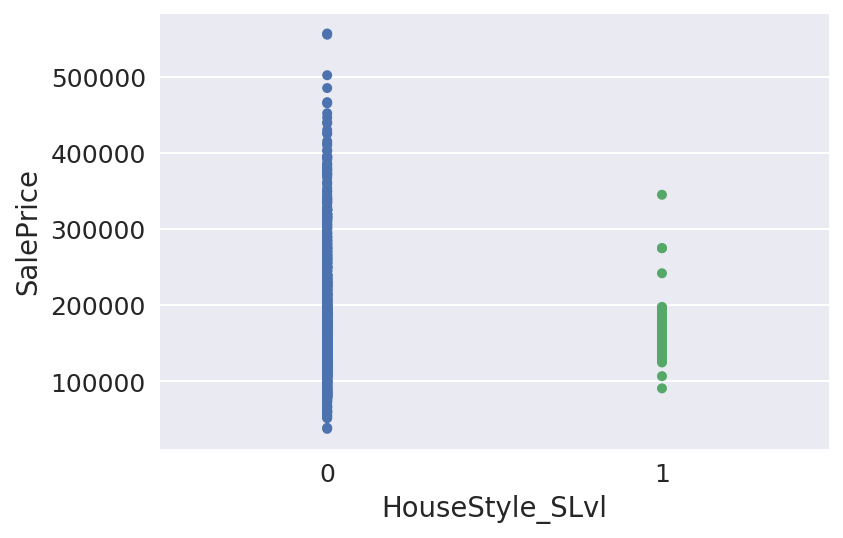

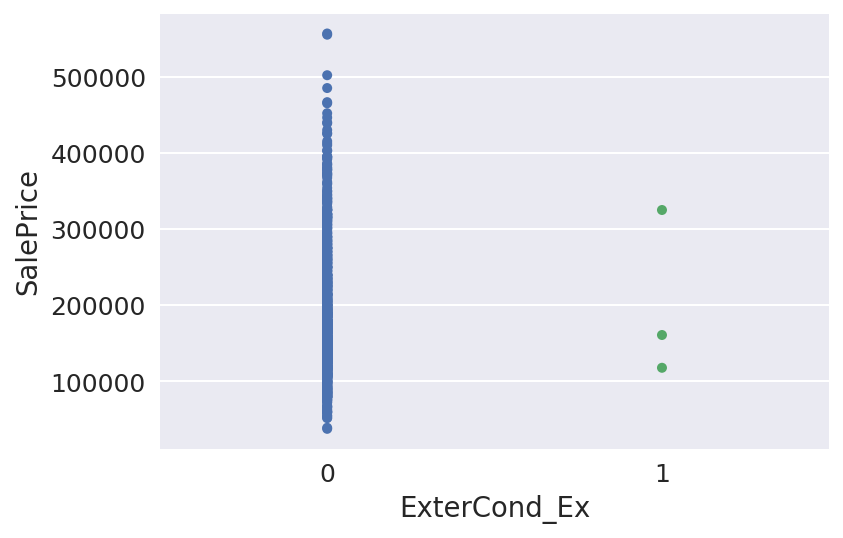

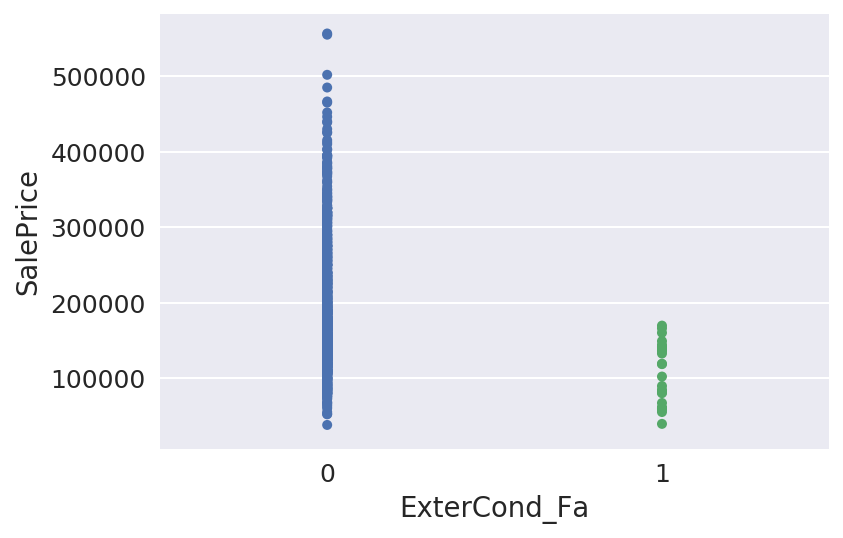

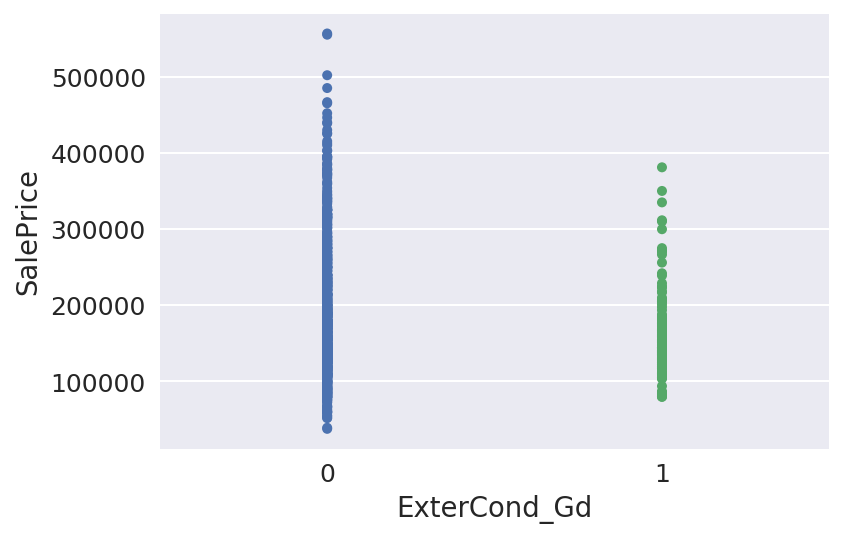

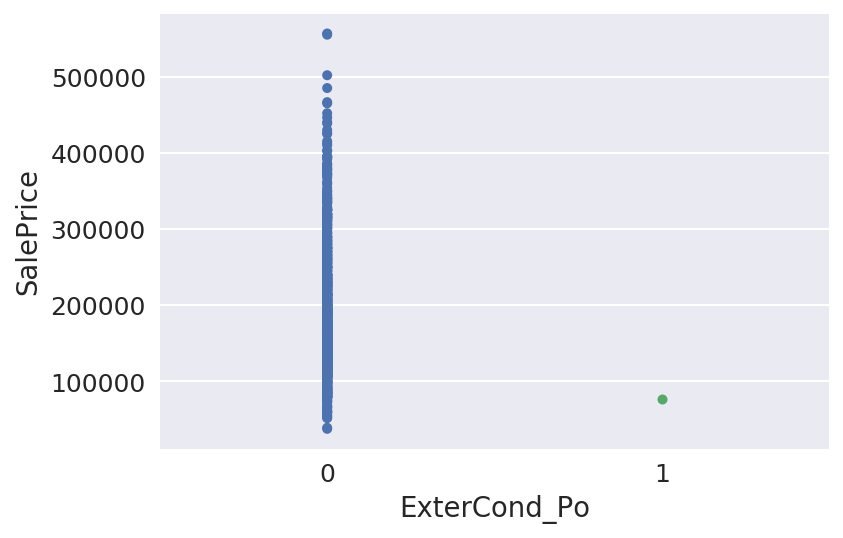

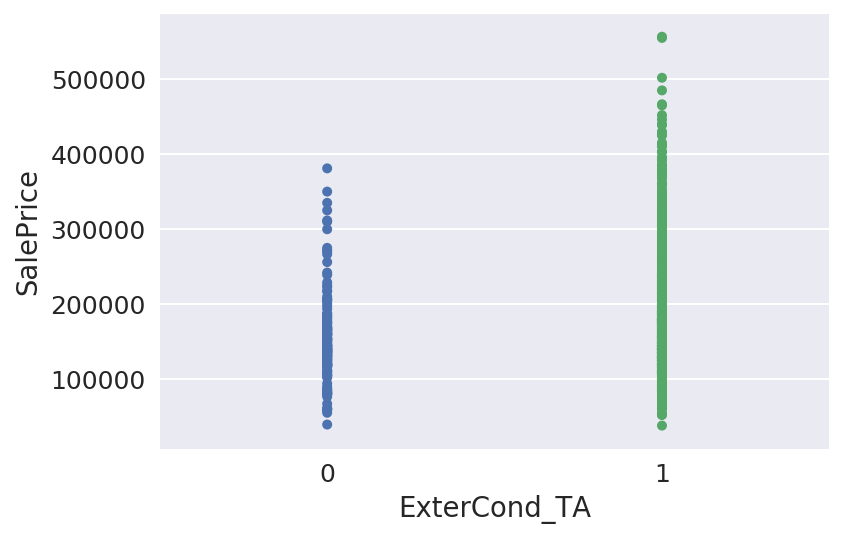

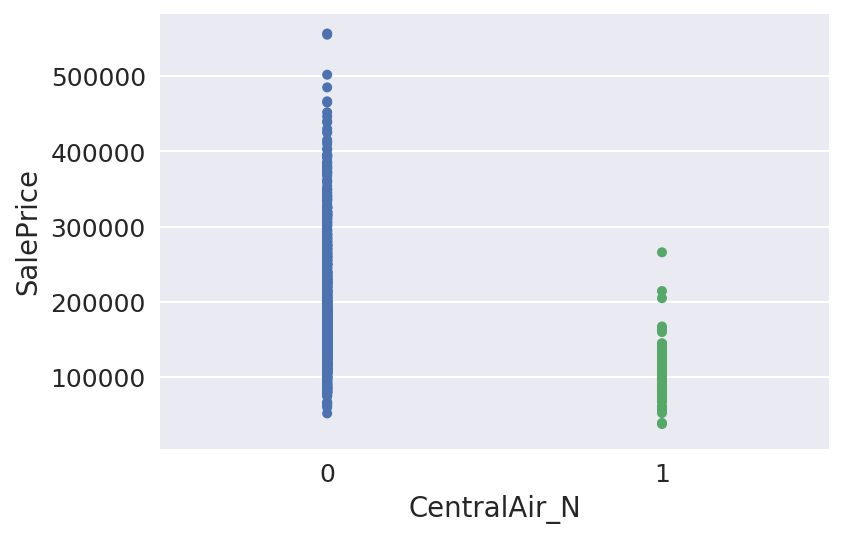

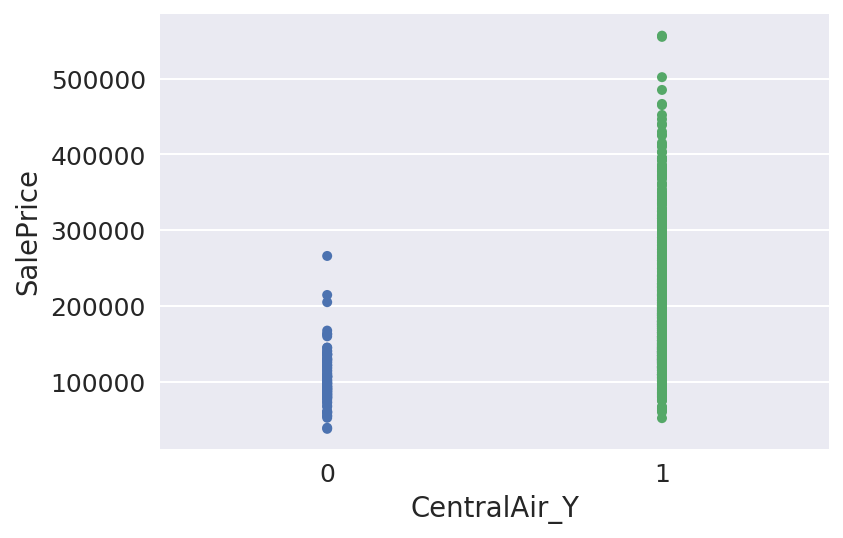

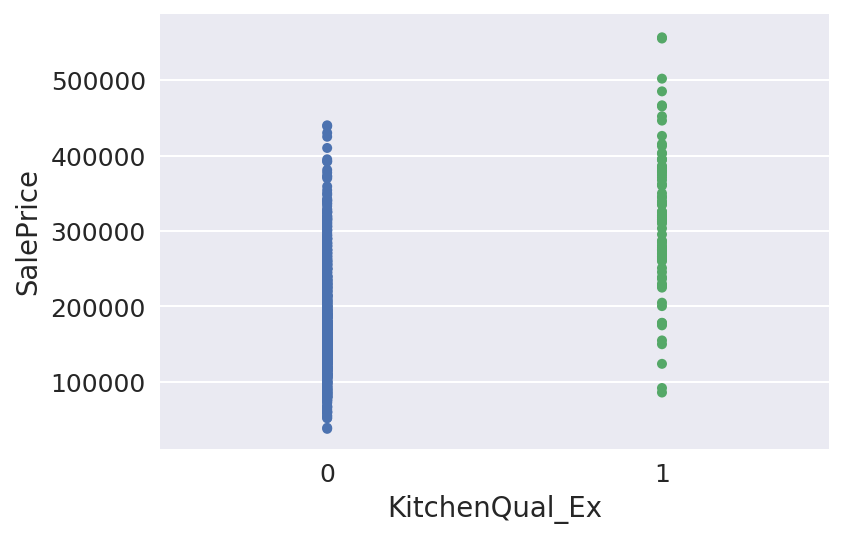

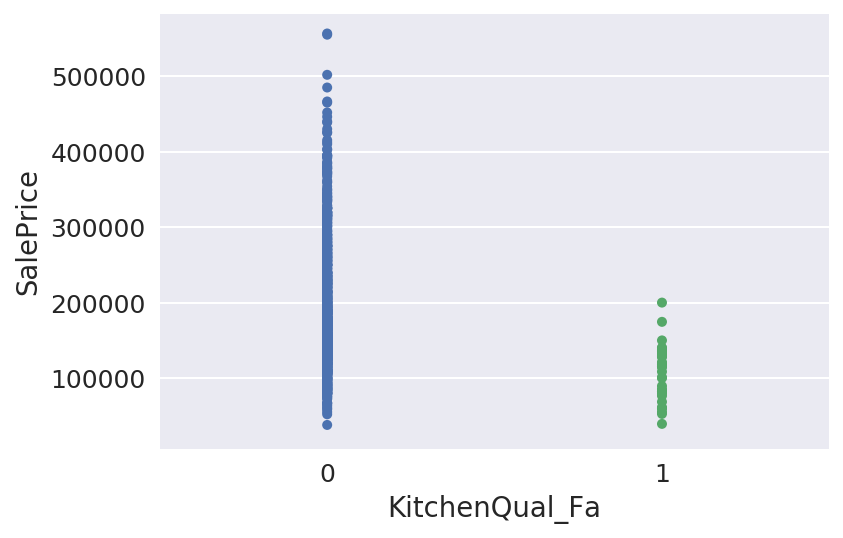

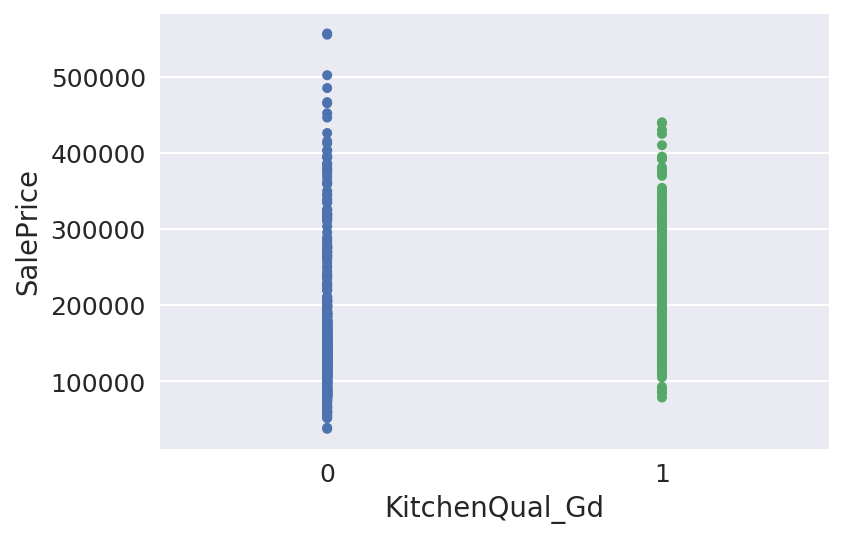

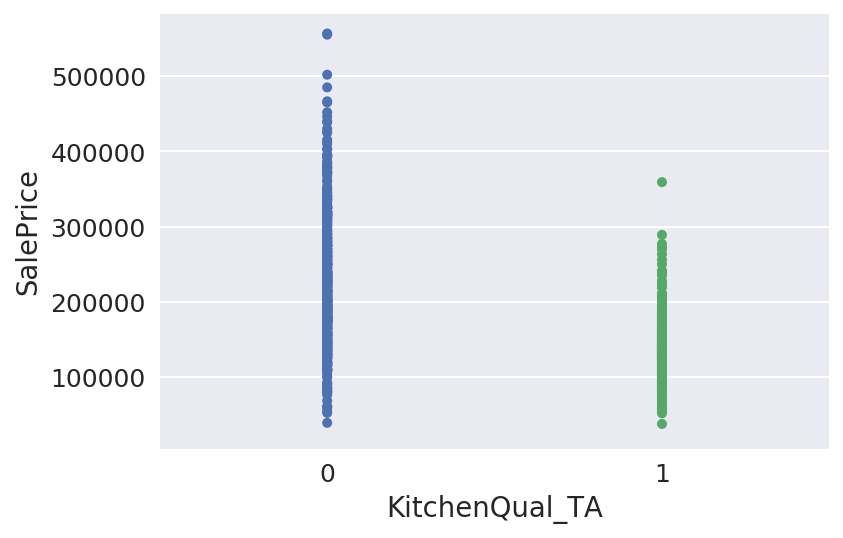

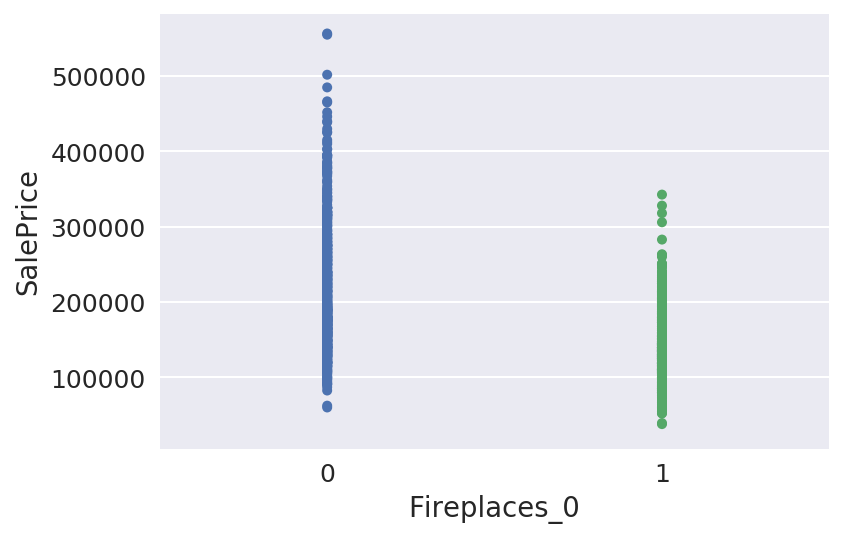

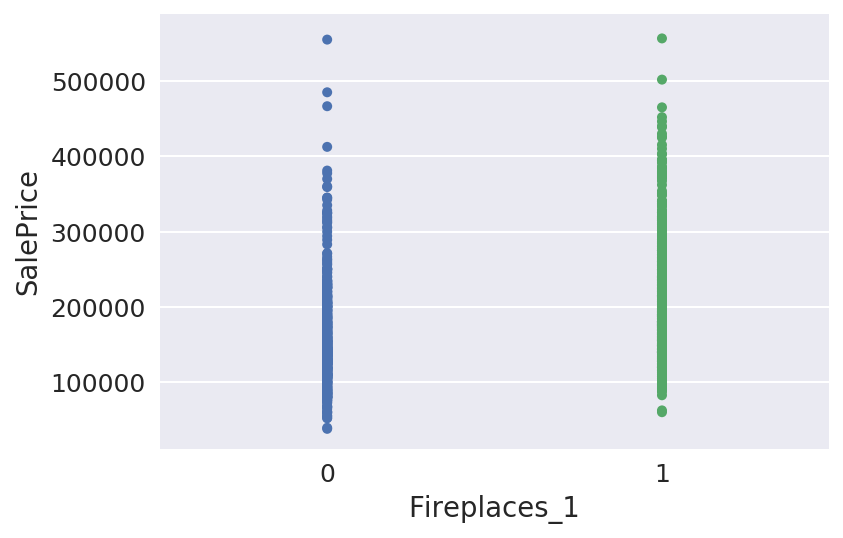

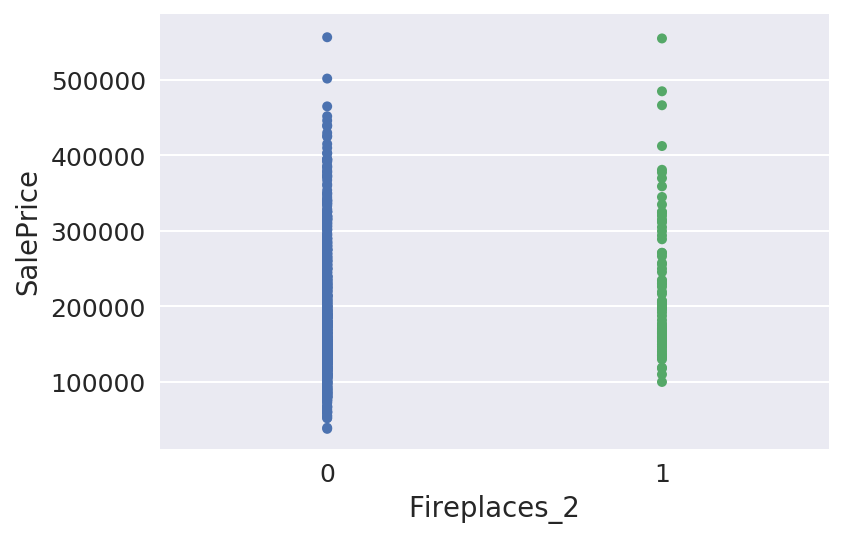

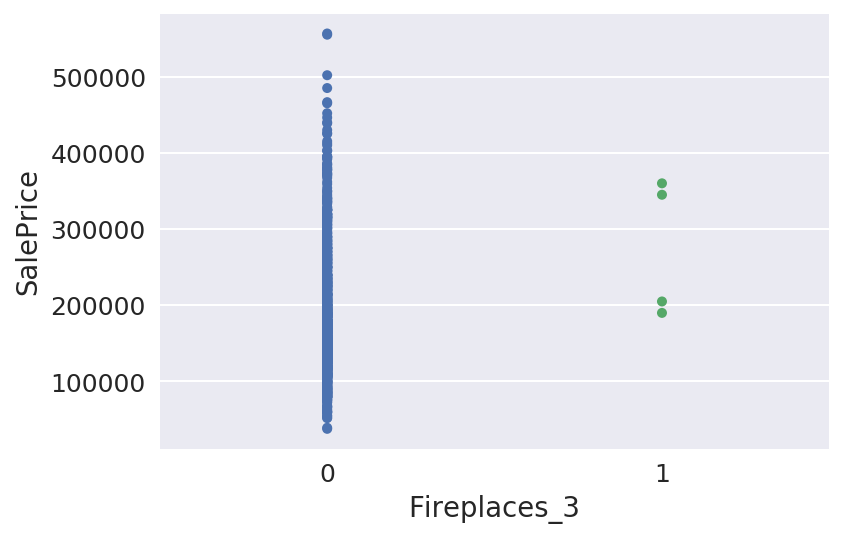

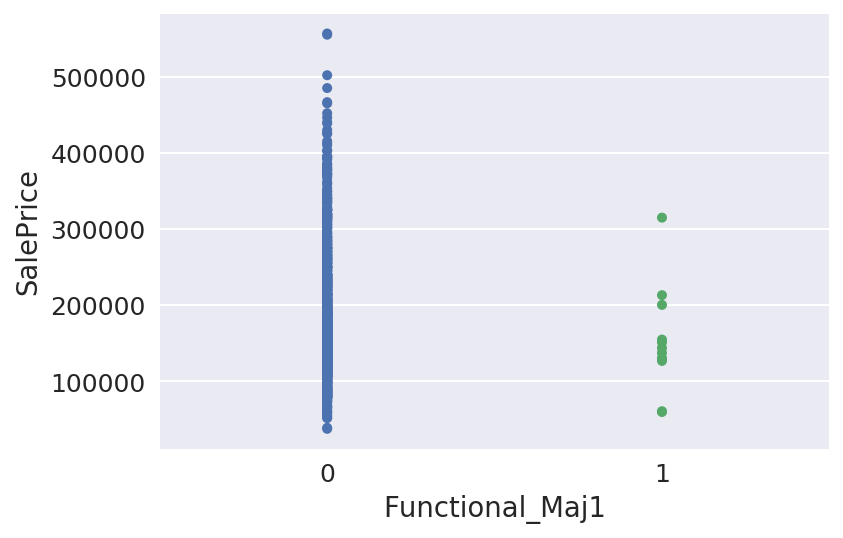

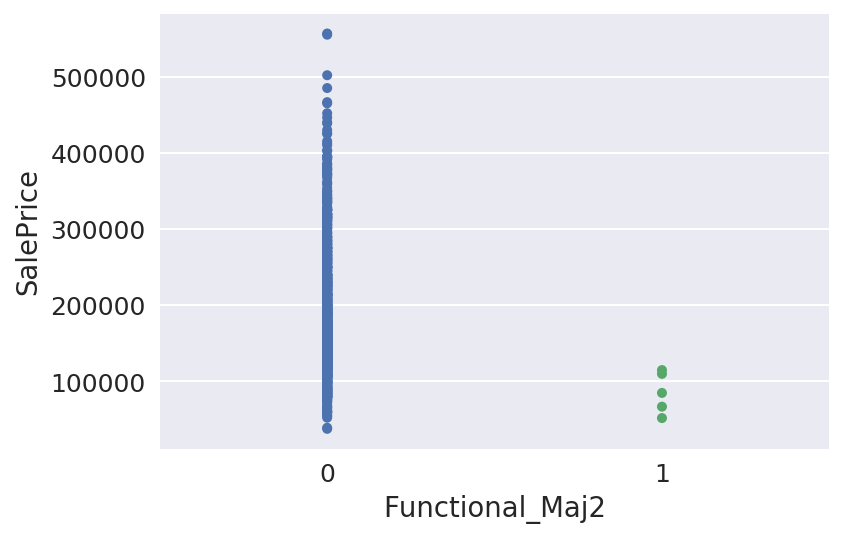

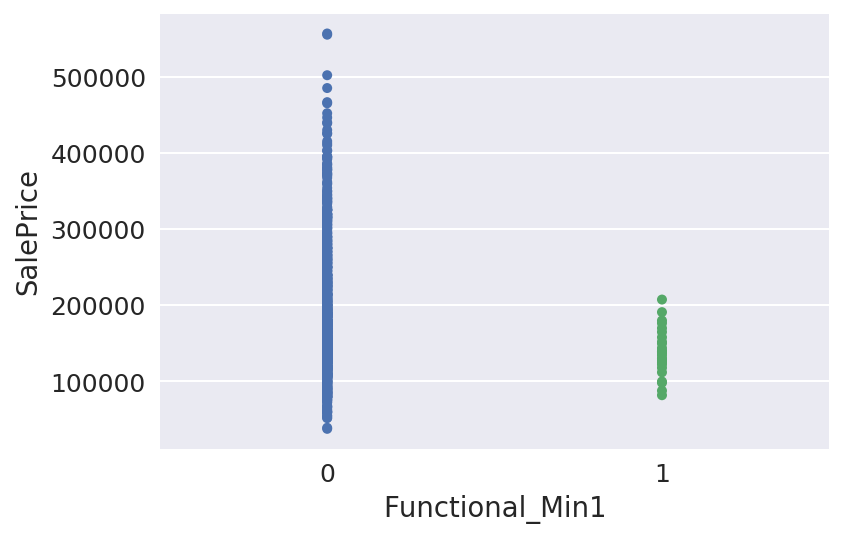

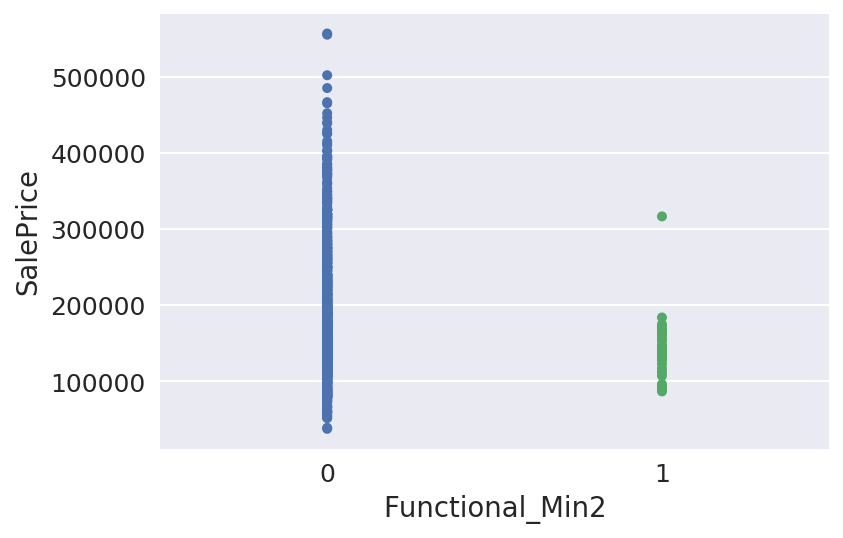

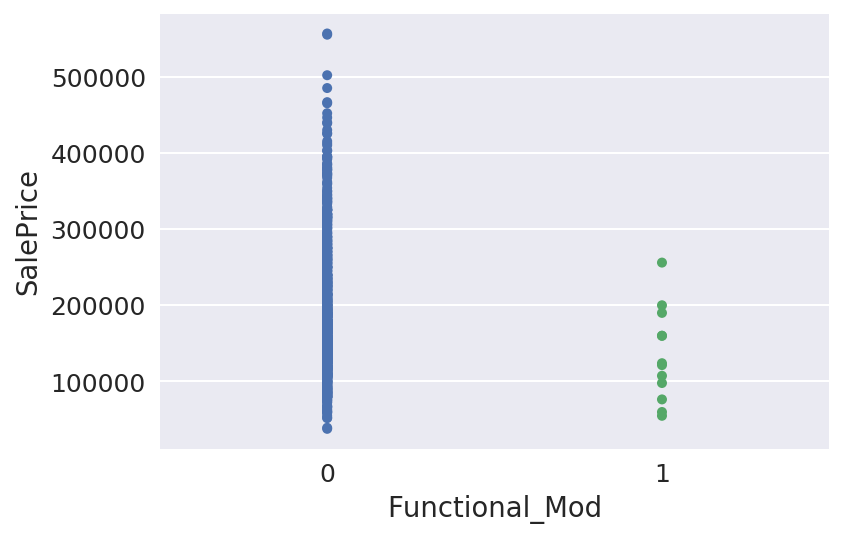

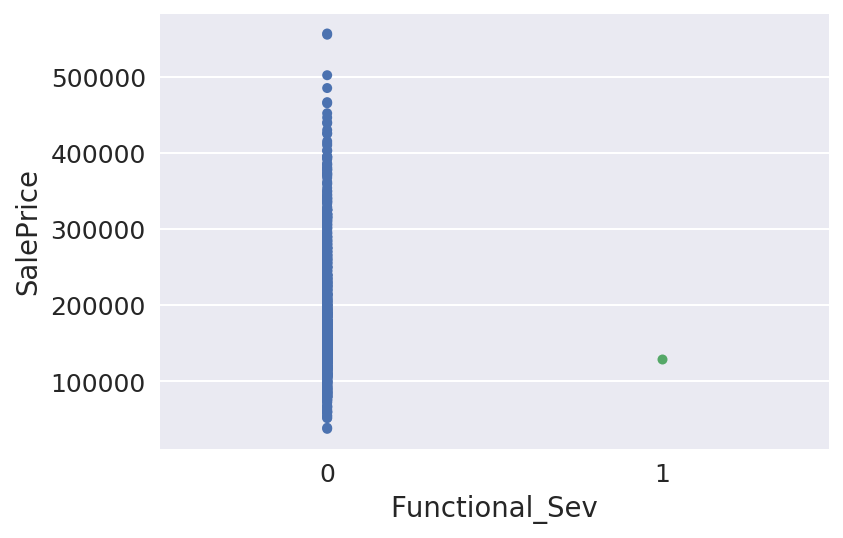

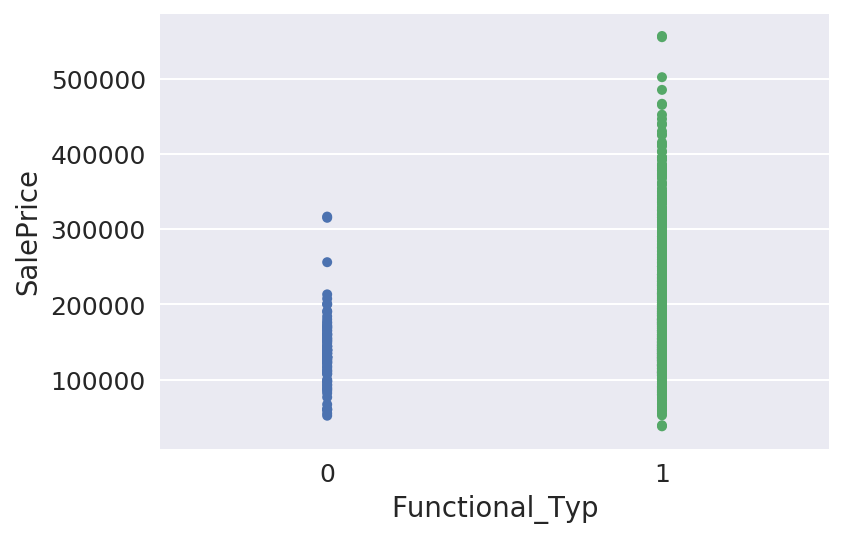

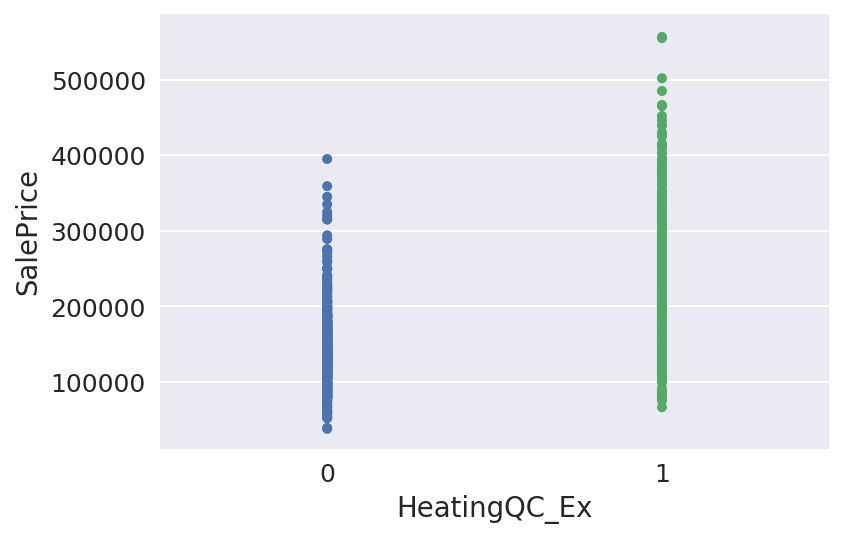

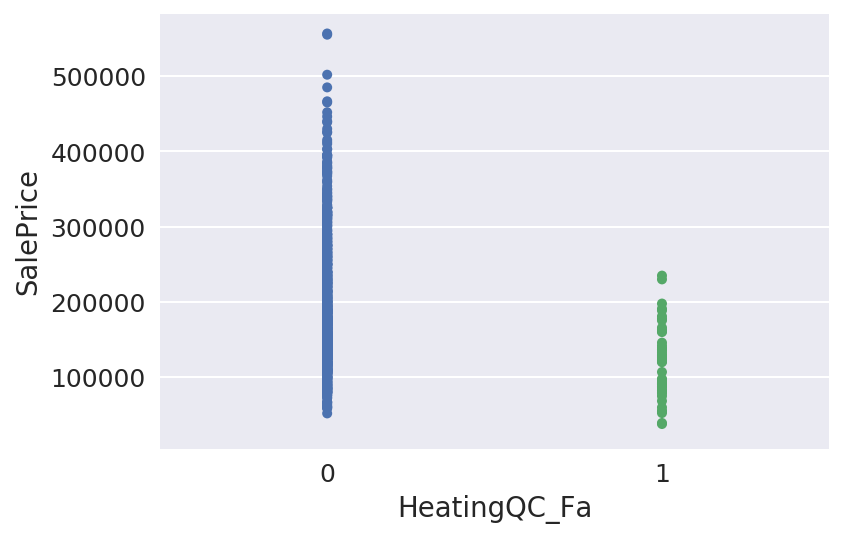

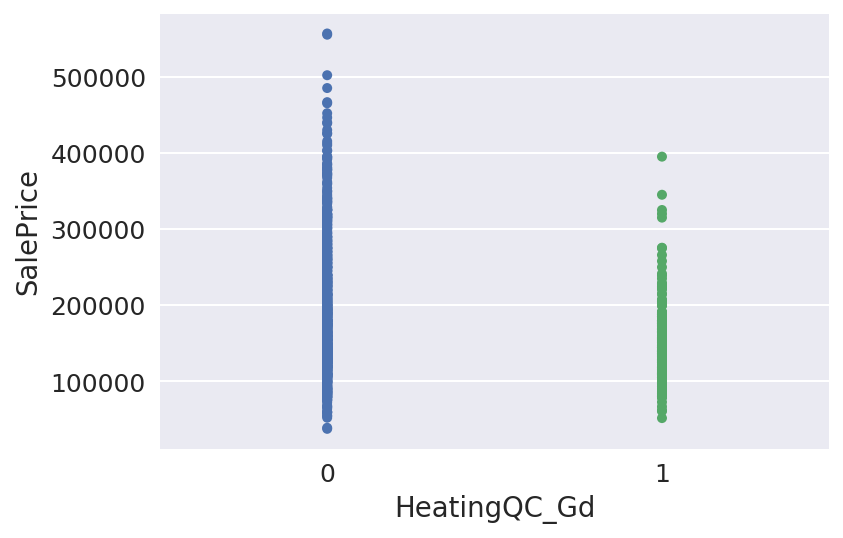

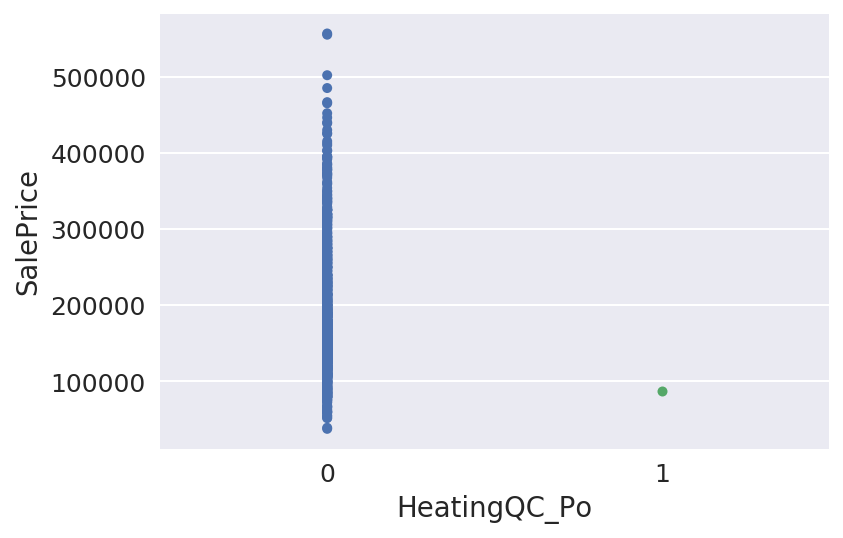

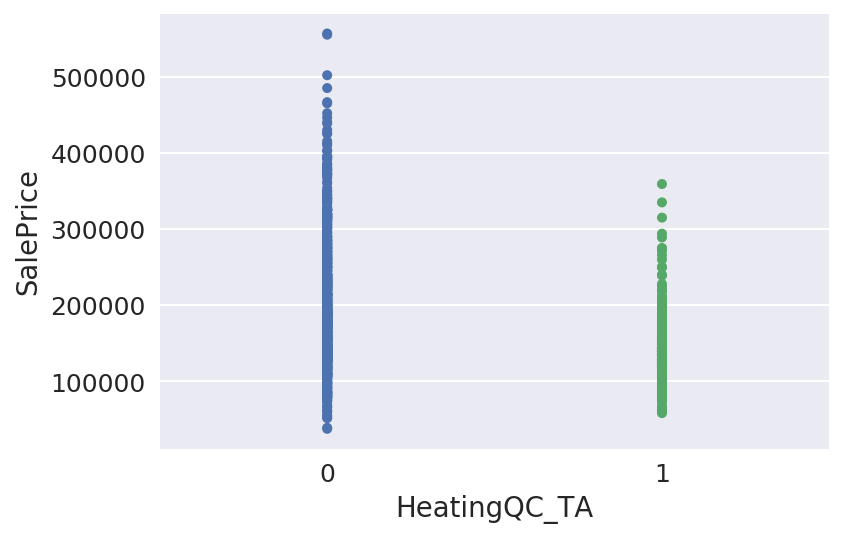

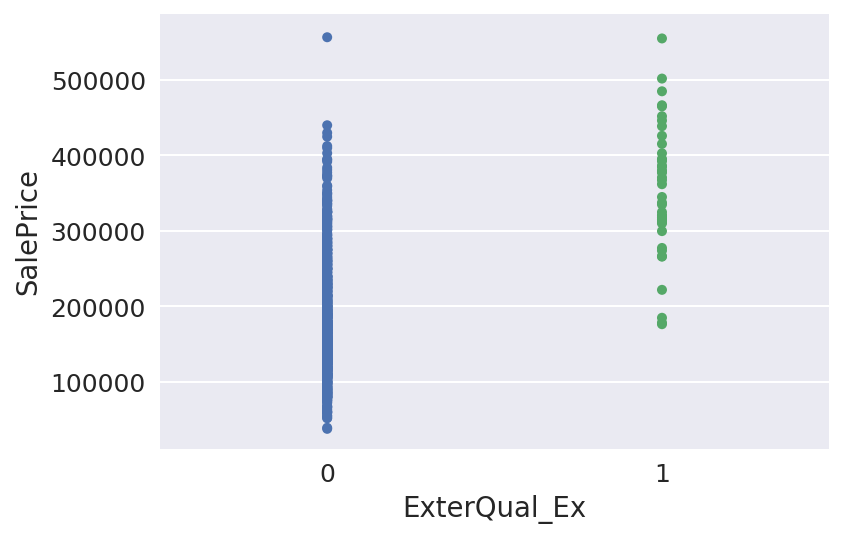

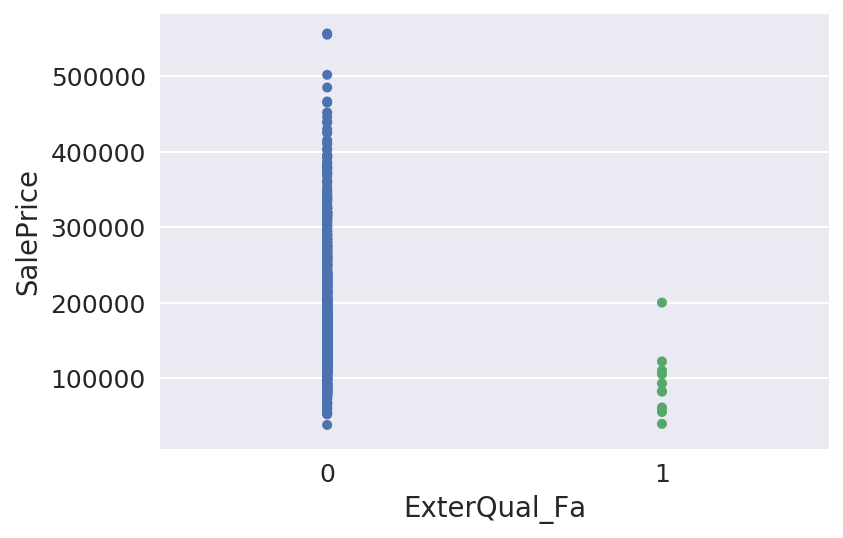

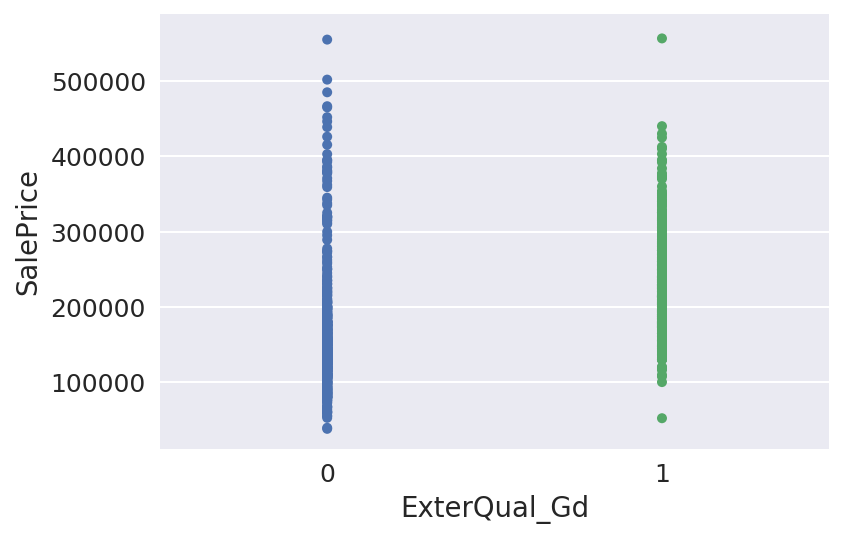

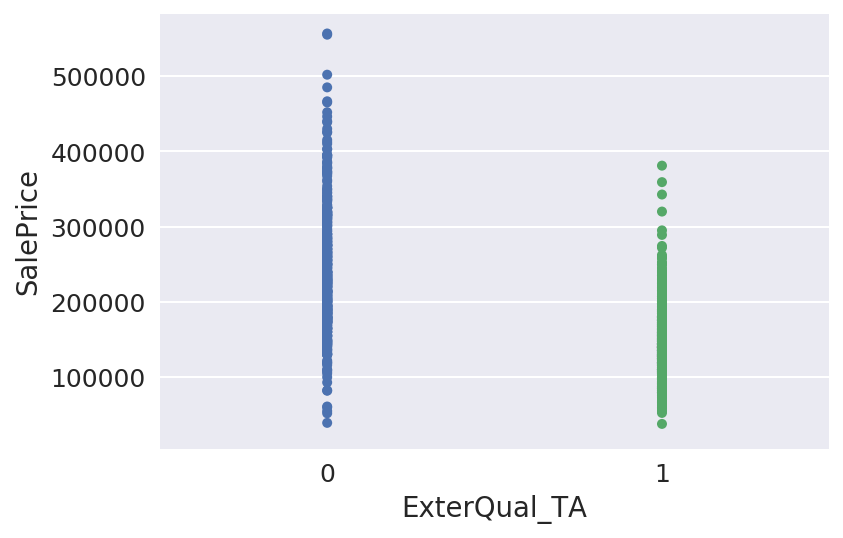

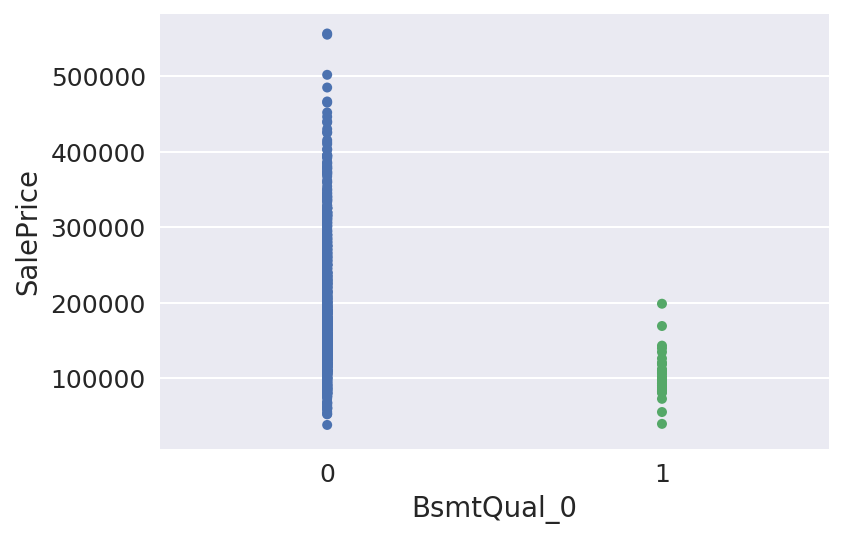

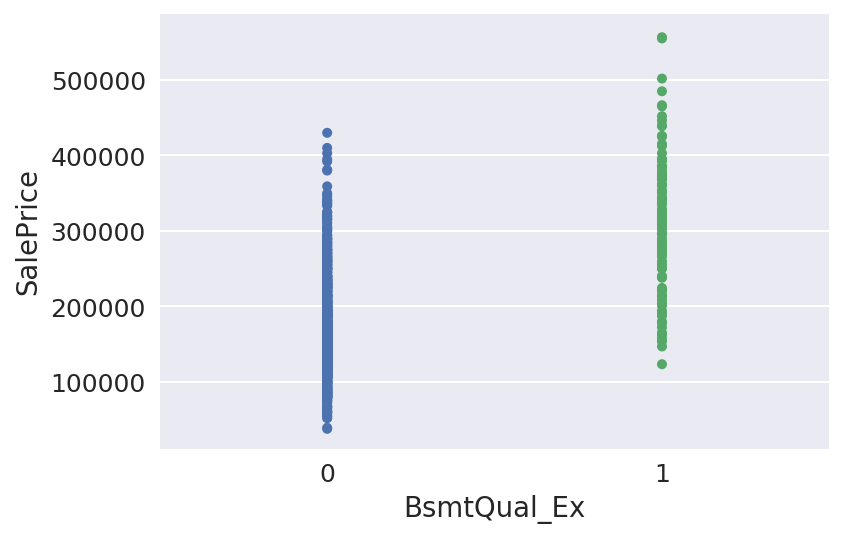

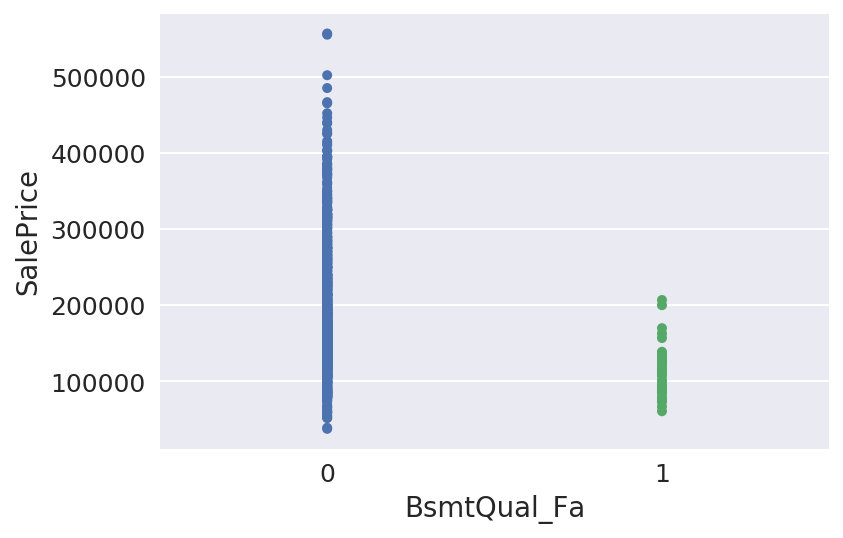

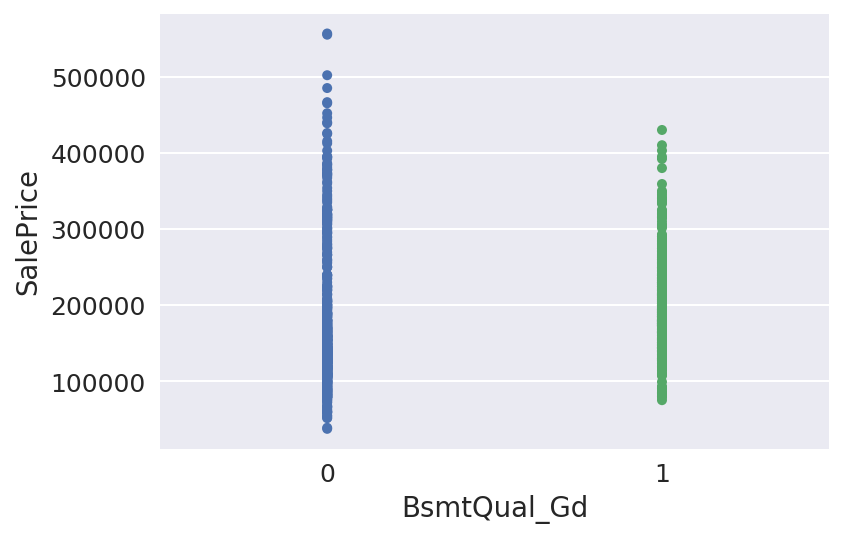

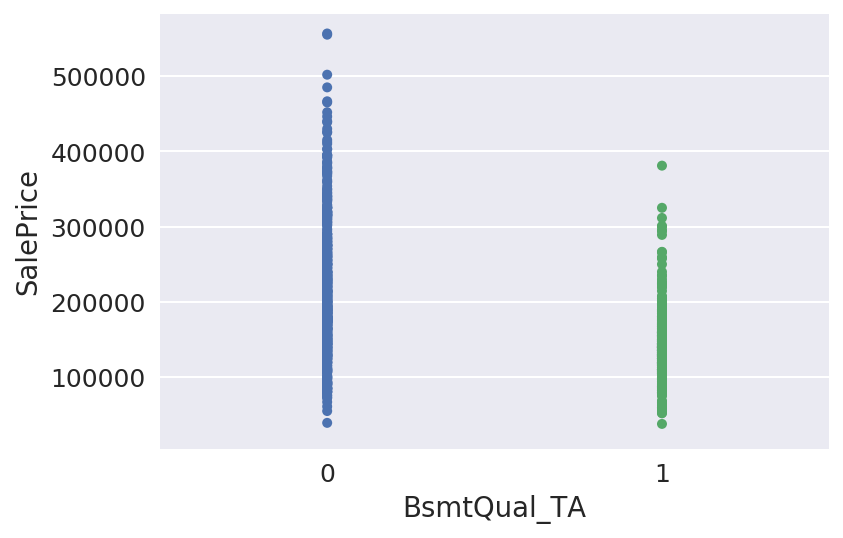

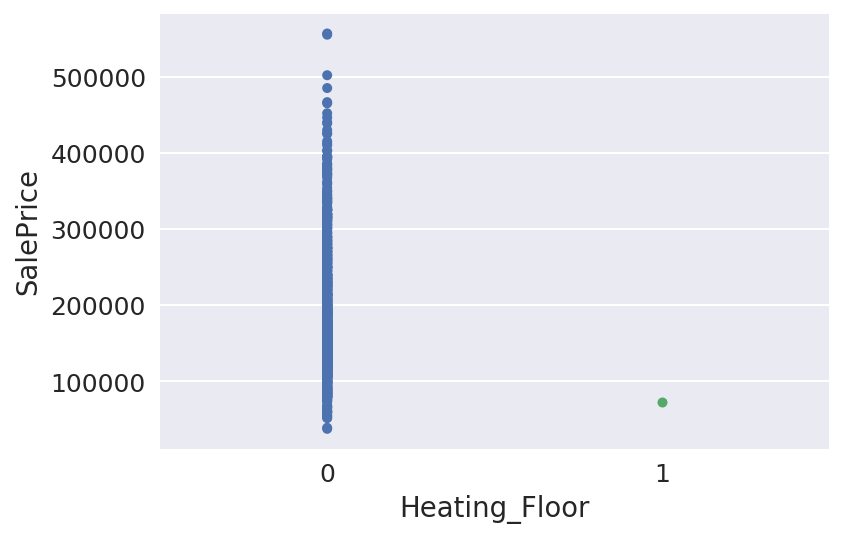

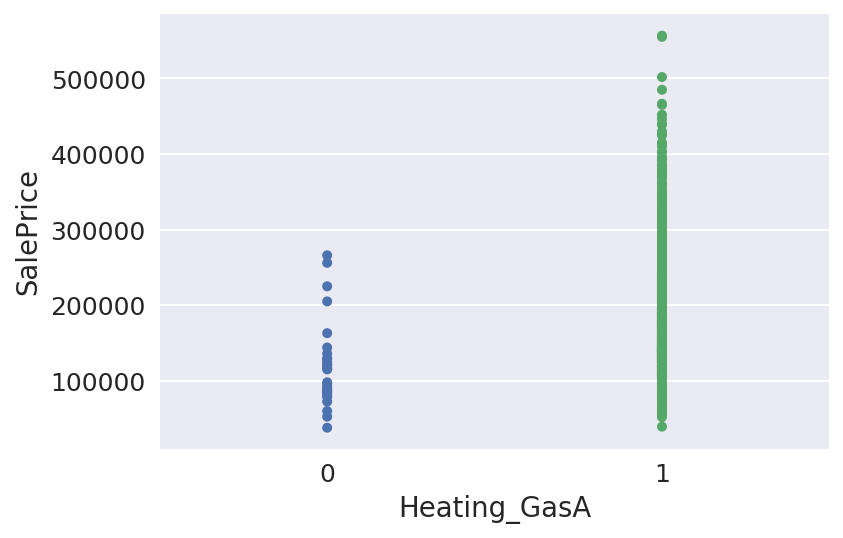

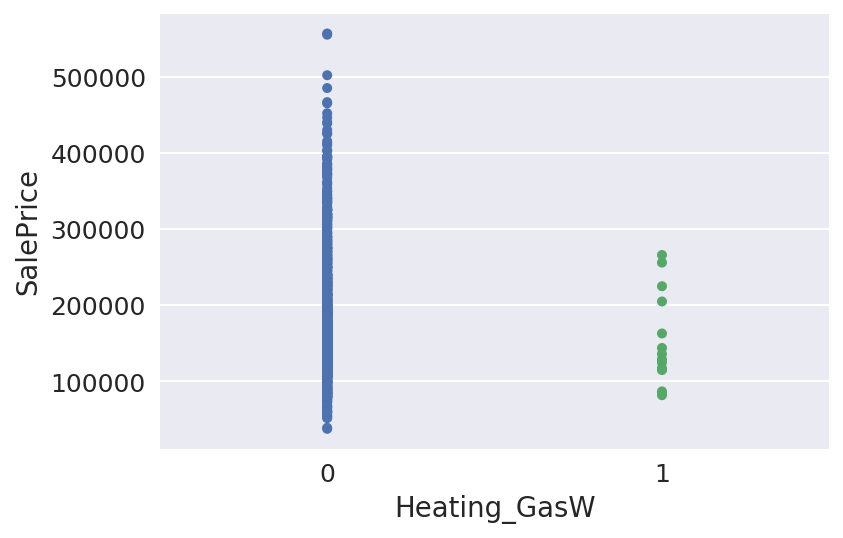

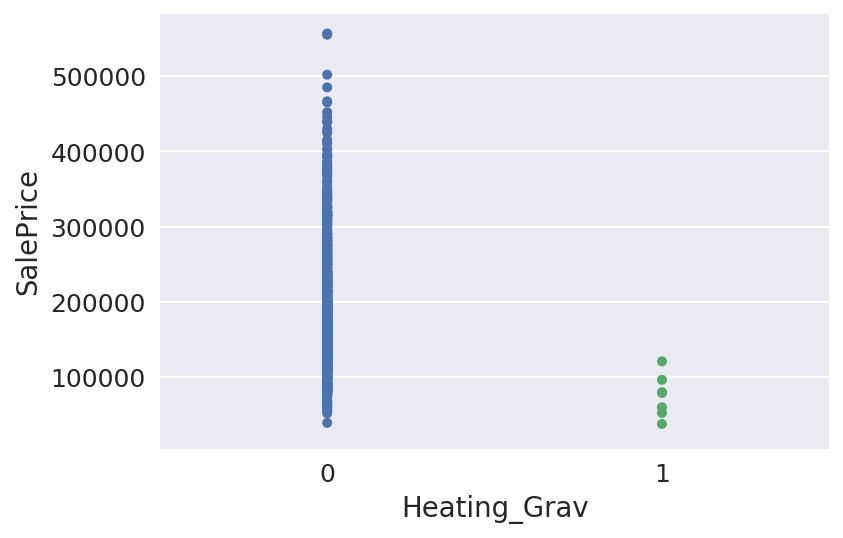

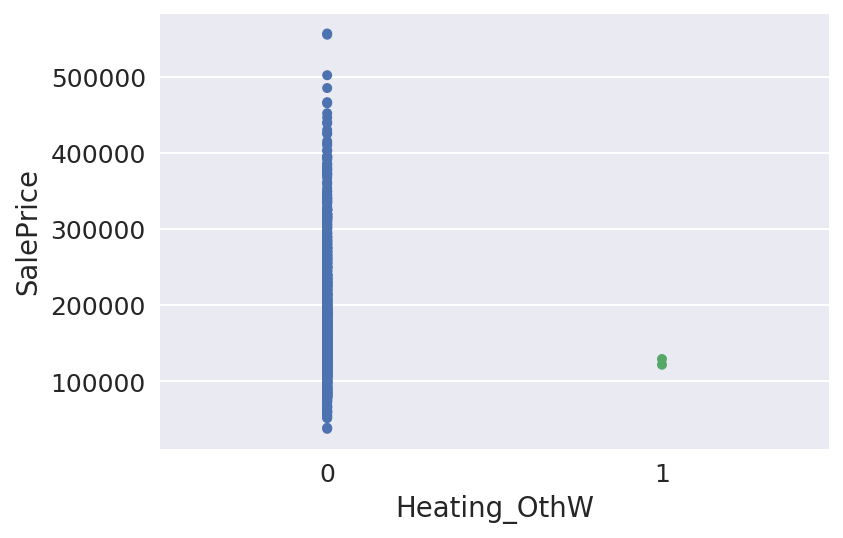

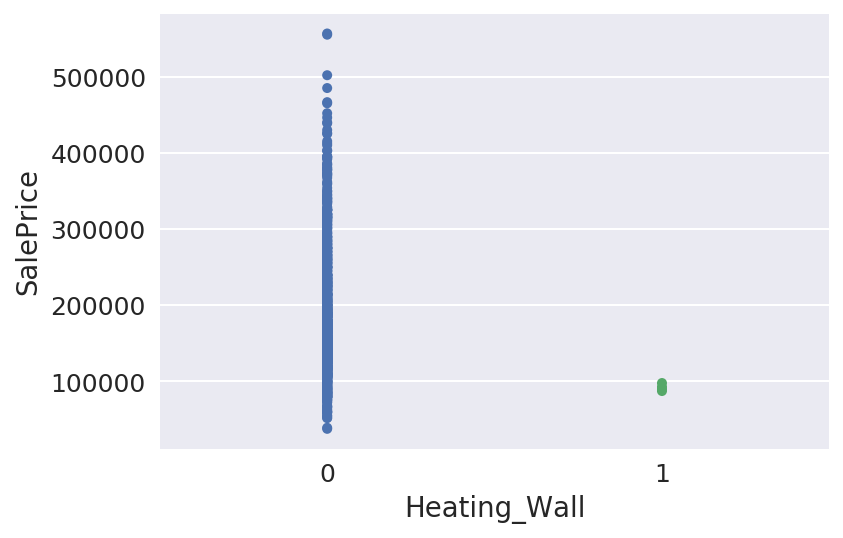

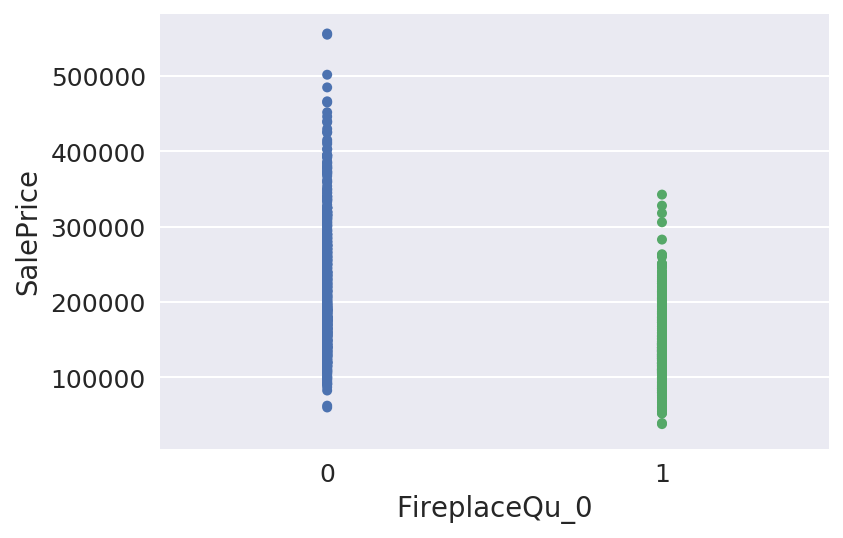

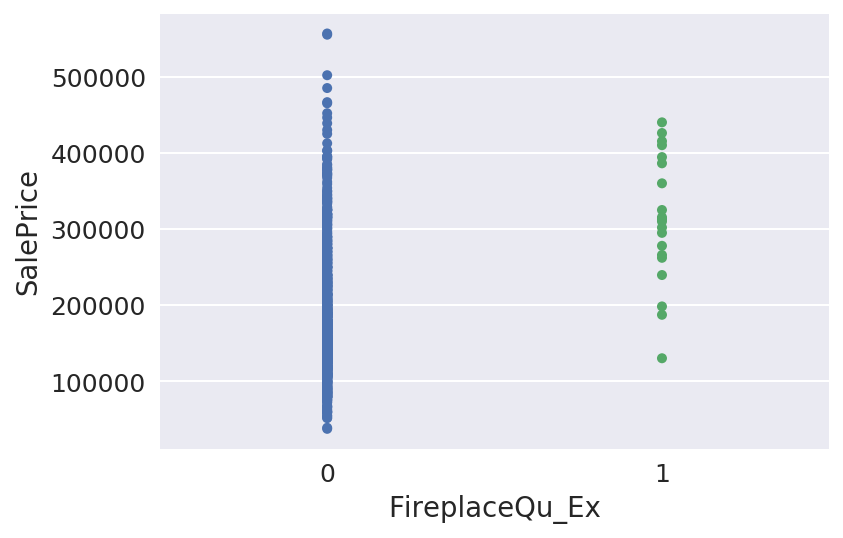

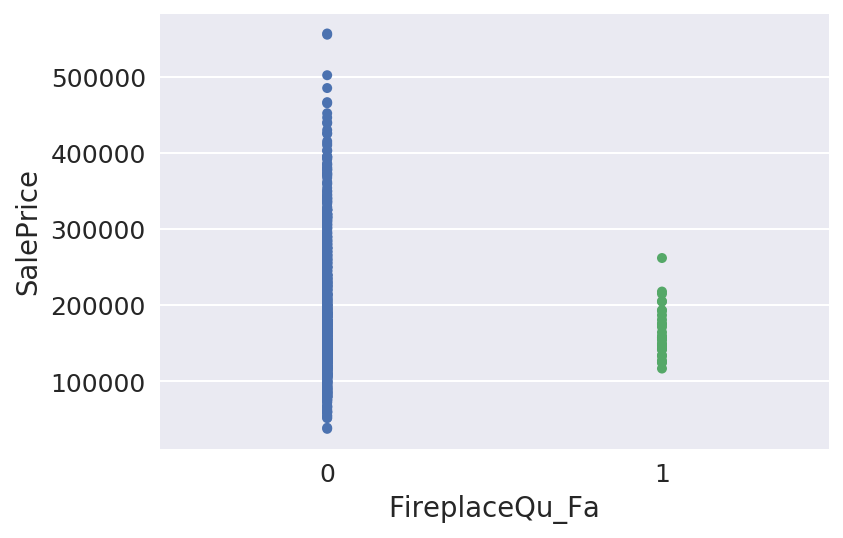

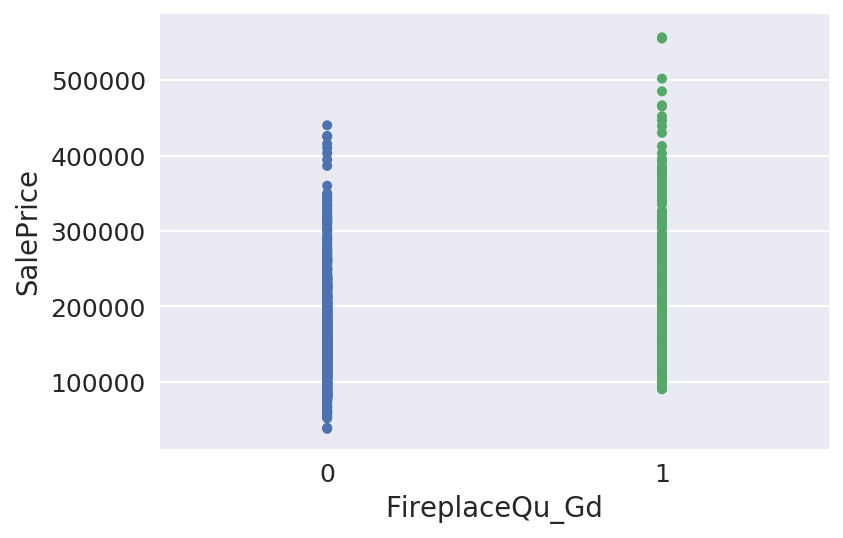

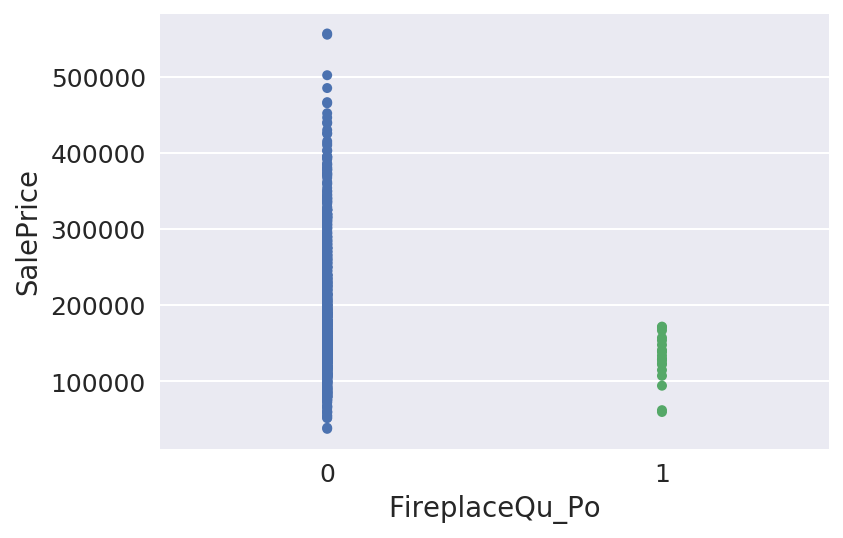

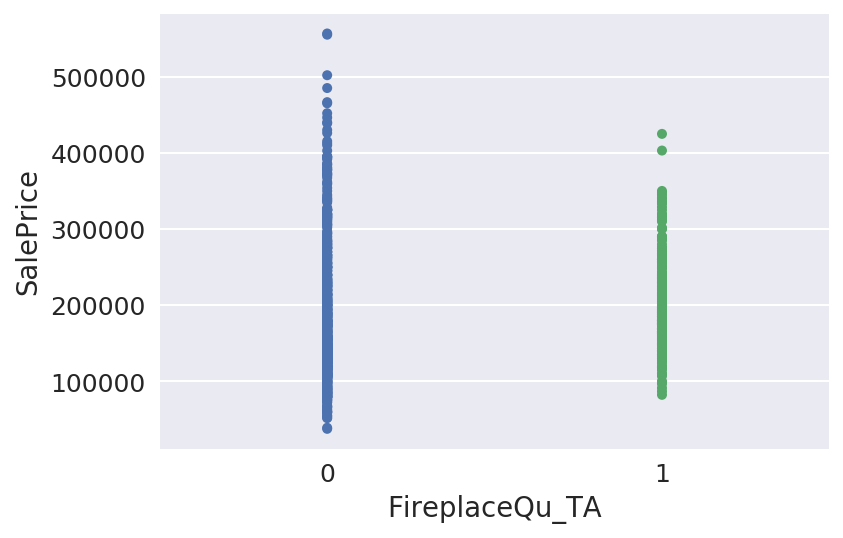

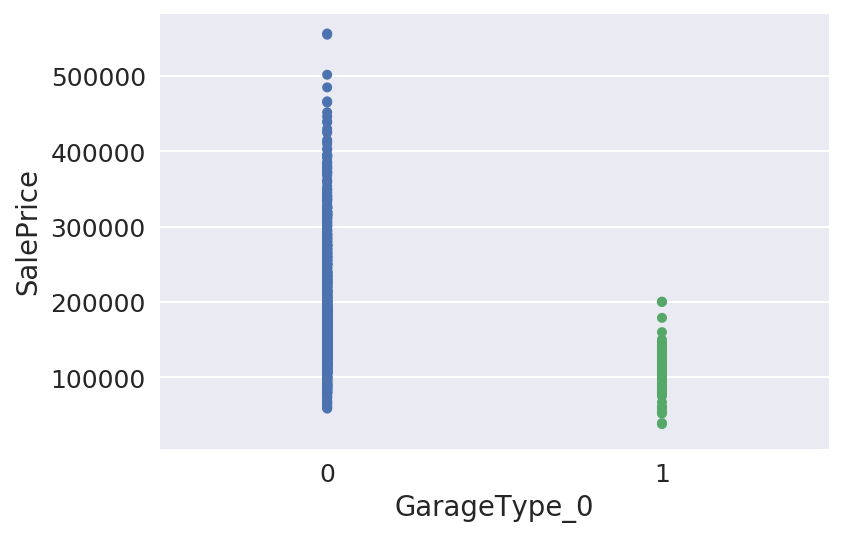

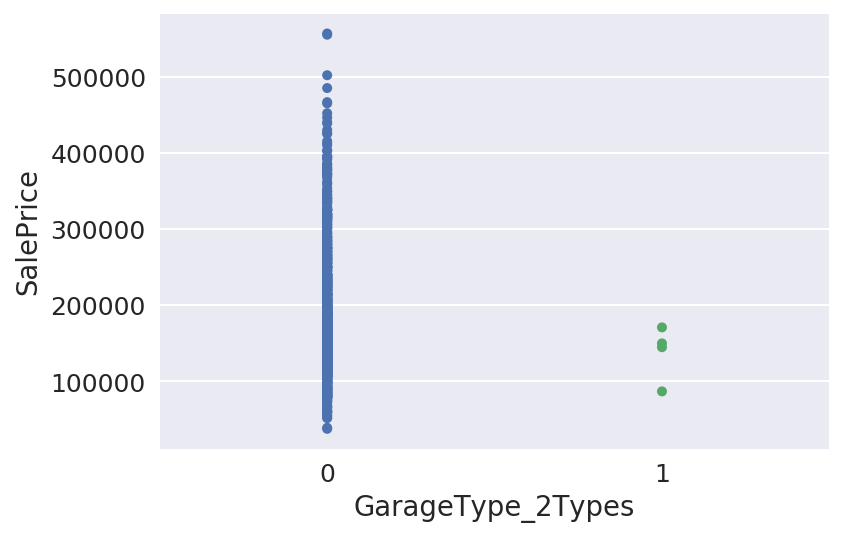

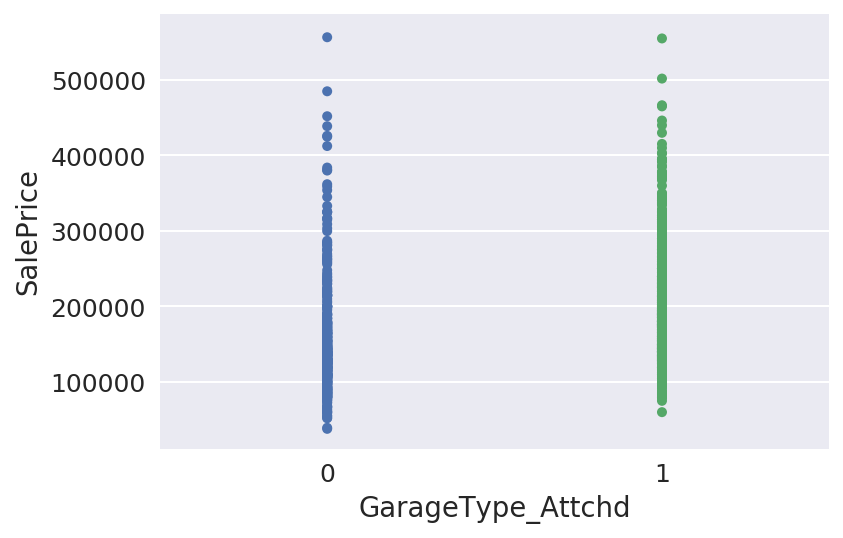

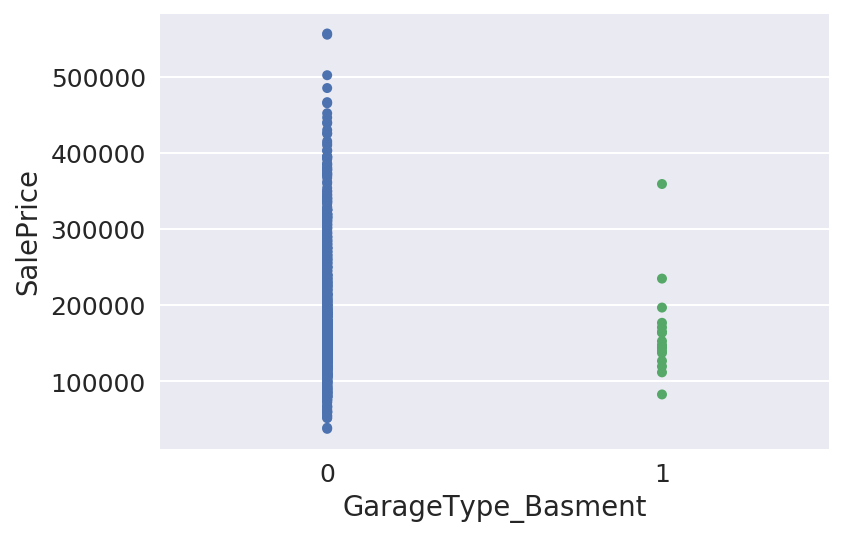

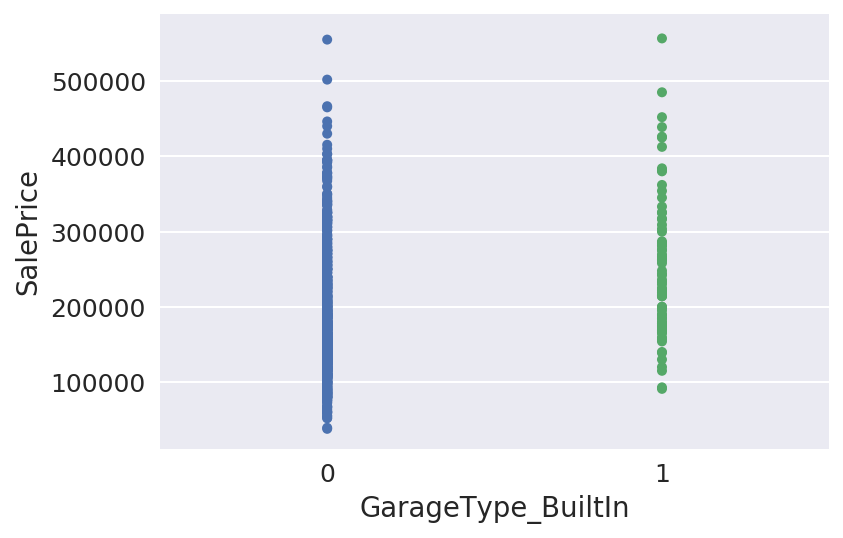

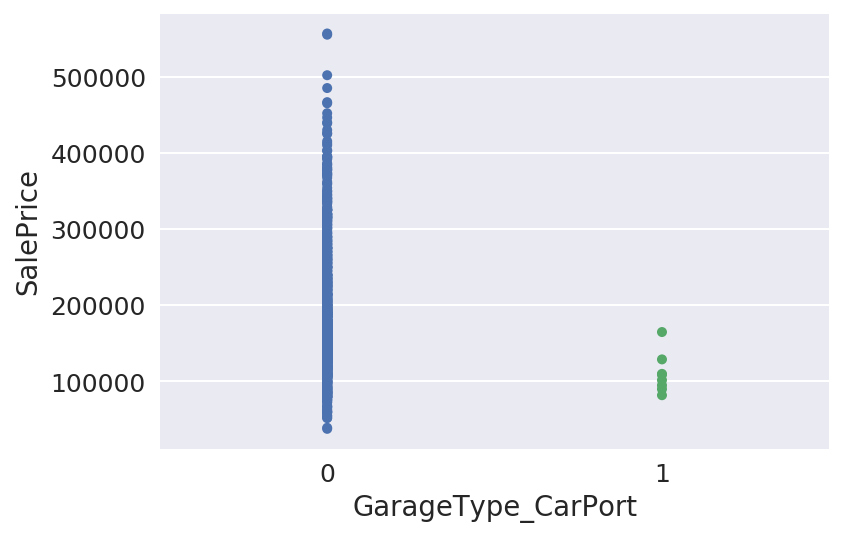

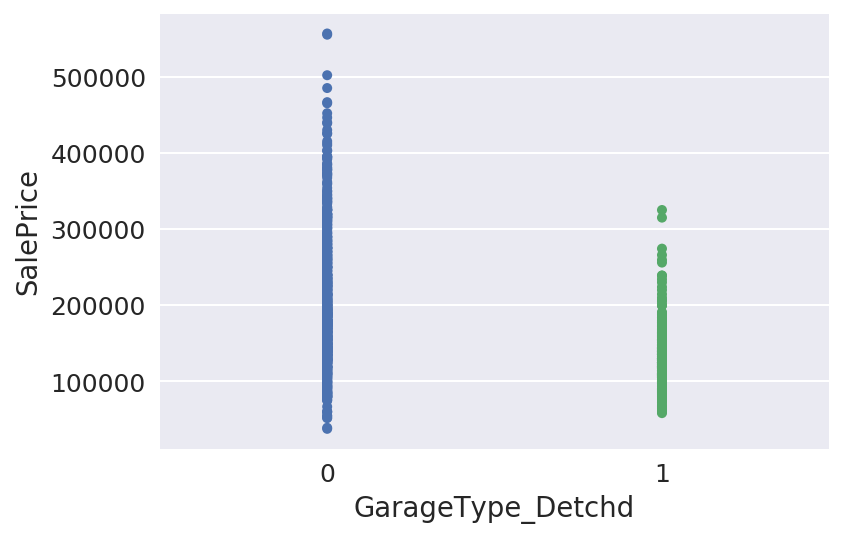

In [37]:
for i in house2.columns:
    sns.stripplot(i, 'SalePrice', data=house2)
    plt.show()


In [38]:
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 41)
(162, 64)


### Using renovatable features to predict house prices

In [39]:
y = house2.loc[:,'SalePrice']
x = house2.loc[:, house2.columns!='SalePrice']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=8)
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape


(162, 41)
(162, 64)


/home/james/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Running linear regression with cross validation

In [40]:
#Trying linear regression
print house1.loc[house1['YrSold'] == 2010].shape
print house2.loc[house2['YrSold'] == 2010].shape

cls_scores = cross_val_score(LinearRegression(), x,y, cv=4)

print cls_scores
np.mean(cls_scores)


(162, 41)
(162, 64)
[-13767006086536986624.000000 0.751788 0.746550 -16312216842735972.000000]


-3.4458295758449306e+18

### Also trying ElasticNet

In [41]:
cls_scores = cross_val_score(ElasticNet(alpha=0.5, l1_ratio=0.001), x,y, cv=4)

print 'Here are my elastic net scores'
print cls_scores
cls_scores.dtype

from sklearn.model_selection import GridSearchCV

enet_params = {'alpha': [0.01,0.1,0.5,1], 'l1_ratio':[0.1,0.5]}
enet_gridsearch = GridSearchCV(ElasticNet(), enet_params, cv=2, verbose=1)
enet_gridsearch.fit(x, y)
print 'gridsearching: best score'
print enet_gridsearch.best_score_
print 'gridsearch best params'
print enet_gridsearch.best_params_
best_enet = enet_gridsearch.best_estimator_
best_enet.score(X_test, y_test)

Here are my elastic net scores
[0.721147 0.681081 0.704948 0.694930]
Fitting 2 folds for each of 8 candidates, totalling 16 fits
gridsearching: best score
0.762851827165
gridsearch best params
{'alpha': 0.01, 'l1_ratio': 0.5}


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished


0.76237875754477413

### Making (yhat - y) my target variable. 

Let's see if we can use renovatable features to predict the residuals from our models in part 1 

In [42]:
#We have 162 yhats. Predict our yhats ?
new_house2 = house2.loc[house2['YrSold'] == 2010]
print y_hat.shape
print new_house2.shape
new_house2.assign(resi = residuals) 

y = residuals
x = new_house2.loc[:, house2.columns!='residuals']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=8)

from xgboost import XGBRegressor
model = XGBRegressor(seed=42, learning_rate=0.1)
model.fit(X_train, y_train)
model.score(X_test, y_test)



(162,)
(162, 64)


0.25873358172614436

# Future work:

* Try using regressor trees and Random Forest to tackle this problem

* Try using the features that were seemingly unimportant